# Neural Networks & Intelligent Computer Systems
## **Exercise 2**. Unsupervised Learning: Recommendation System

---
Christos Dimopoulos - 03117037 <br />
Dimitris Dimos - 03117165 <br />
Team No. 01
---

# Εργαστηριακή Άσκηση 2. Μη επιβλεπόμενη μάθηση. 
## Σύστημα συστάσεων βασισμένο στο περιεχόμενο
## Σημασιολογική απεικόνιση δεδομένων με χρήση SOM 
Ημερομηνία εκφώνησης της άσκησης: 23 Νοεμβρίου 2021

**Θα βρείτε το παρόν σε μορφή jupyter notebook ως συνημμένο στο τέλος της εκφώνησης.**


In [ ]:
!pip install --upgrade pip
!pip install --upgrade numpy
!pip install --upgrade pandas
!pip install --upgrade nltk
!pip install --upgrade scikit-learn
!pip install --upgrade joblib

In [3]:
# Collect all Imports
import pandas as pd
import numpy as np
import re
import contractions
from nltk.stem import WordNetLemmatizer
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import urllib
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy
import gensim.downloader as api
from scipy.sparse import csr_matrix
import joblib
import somoclu
import matplotlib
from sklearn.cluster import KMeans
from nltk.stem import WordNetLemmatizer


In [26]:
corpus_tf_idf_plain = joblib.load('corpus_tf_idf_plain.pkl')
corpus_tf_idf_optimal = joblib.load('corpus_tf_idf_optimal.pkl') 
tfw2v_corpus = joblib.load('tfw2v_corpus.pkl')

## Εισαγωγή του Dataset

Το σύνολο δεδομένων με το οποίο θα δουλέψουμε είναι βασισμένο στο [Carnegie Mellon Movie Summary Corpus](http://www.cs.cmu.edu/~ark/personas/). Πρόκειται για ένα dataset με 22.301 περιγραφές ταινιών. Η περιγραφή κάθε ταινίας αποτελείται από τον τίτλο της, μια ή περισσότερες ετικέτες που χαρακτηρίζουν το είδος της ταινίας και τέλος τη σύνοψη της υπόθεσής της. Αρχικά εισάγουμε το dataset (χρησιμοποιήστε αυτούσιο τον κώδικα, δεν χρειάζεστε το αρχείο csv) στο dataframe `df_data_1`: 

In [4]:
import pandas as pd

dataset_url = "https://drive.google.com/uc?export=download&id=1-tN5rC1QCgwqL67cvIXdMbtd-Xf9Xqow"
df_data_1 = pd.read_csv(dataset_url, sep='\t',  header=None, quoting=3)

Κάθε ομάδα θα δουλέψει σε **ένα μοναδικό υποσύνολο 5.000 ταινιών** (διαφορετικό dataset για κάθε ομάδα) ως εξής:

1. Κάθε ομάδα του εργαστηρίου νευρωνικών έχει έναν αριθμό στο helios. Θα βάλετε τον αριθμό αυτό στη μεταβλητή team_seed_number στο επόμενο κελί κώδικα.

2. Το data frame `df_data_2` έχει γραμμές όσες και οι ομάδες και 5.000 στήλες. Σε κάθε ομάδα αντιστοιχεί η γραμμή του πίνακα με το `team_seed_number` της. Η γραμμή αυτή θα περιλαμβάνει 5.000 διαφορετικούς αριθμούς που αντιστοιχούν σε ταινίες του αρχικού dataset. 

3. Τρέξτε τον κώδικα. Θα προκύψουν τα μοναδικά για κάθε ομάδα  titles, categories, catbins, summaries και corpus με τα οποία θα δουλέψετε.

In [5]:
import numpy as np

# Στο επόμενη γραμή βάλτε τον αριθμό της ομάδας στο εργαστήριο των νευρωνικών
team_seed_number = 1

movie_seeds_url = "https://drive.google.com/uc?export=download&id=1-oeMf7BFmiH70XObgC9WOTo-a9cDJZwP"
df_data_2 = pd.read_csv(movie_seeds_url, header=None)

# επιλέγεται 
my_index = df_data_2.iloc[team_seed_number,:].values

titles = df_data_1.iloc[:, [2]].values[my_index] # movie titles (string)
categories = df_data_1.iloc[:, [3]].values[my_index] # movie categories (string)
bins = df_data_1.iloc[:, [4]]
catbins = bins[4].str.split(',', expand=True).values.astype(float)[my_index] # movie categories in binary form (1 feature per category)
summaries =  df_data_1.iloc[:, [5]].values[my_index] # movie summaries (string)
corpus = summaries[:,0].tolist() # list form of summaries
corpus_df = pd.DataFrame(corpus) # dataframe version of corpus

- Ο πίνακας **titles** περιέχει τους τίτλους των ταινιών. Παράδειγμα: 'Sid and Nancy'.
- O πίνακας **categories** περιέχει τις κατηγορίες (είδη) της ταινίας υπό τη μορφή string. Παράδειγμα: '"Tragedy",  "Indie",  "Punk rock",  "Addiction Drama",  "Cult",  "Musical",  "Drama",  "Biopic \[feature\]",  "Romantic drama",  "Romance Film",  "Biographical film"'. Παρατηρούμε ότι είναι μια comma separated λίστα strings, με κάθε string να είναι μια κατηγορία.
- Ο πίνακας **catbins** περιλαμβάνει πάλι τις κατηγορίες των ταινιών αλλά σε δυαδική μορφή ([one hot encoding](https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f)). Έχει διαστάσεις 5.000 x 322 (όσες οι διαφορετικές κατηγορίες). Αν η ταινία ανήκει στο συγκεκριμένο είδος η αντίστοιχη στήλη παίρνει την τιμή 1, αλλιώς παίρνει την τιμή 0.
- Ο πίνακας **summaries** και η λίστα **corpus** περιλαμβάνουν τις συνόψεις των ταινιών (η corpus είναι απλά ο summaries σε μορφή λίστας). Κάθε σύνοψη είναι ένα (συνήθως μεγάλο) string. Παράδειγμα: *'The film is based on the real story of a Soviet Internal Troops soldier who killed his entire unit  as a result of Dedovschina. The plot unfolds mostly on board of the prisoner transport rail car guarded by a unit of paramilitary conscripts.'*
- το dataframe corpus_df που είναι απλά το corpus σε μορφή dataframe. Τα summaries βρίσκονται στην κολόνα 0. Πιθανώς να σας βολεύει να κάνετε κάποιες προεπεξεργασίες με dataframes.


Θεωρούμε ως **ID** της κάθε ταινίας τον αριθμό γραμμής της ή το αντίστοιχο στοιχείο της λίστας. Παράδειγμα: για να τυπώσουμε τη σύνοψη της ταινίας με `ID=999` (την χιλιοστή) θα γράψουμε `print(corpus[999])`.

In [168]:
ID = 999
print(titles[ID])
print(categories[ID])
print(catbins[ID])
print(corpus[ID])

['Sons of the Sea']
['"War film"']
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 

# Εφαρμογή 1. Υλοποίηση συστήματος συστάσεων ταινιών βασισμένο στο περιεχόμενο
<img src="http://clture.org/wp-content/uploads/2015/12/Netflix-Streaming-End-of-Year-Posts.jpg" width="70%">

Η πρώτη εφαρμογή που θα αναπτύξετε θα είναι ένα [σύστημα συστάσεων](https://en.wikipedia.org/wiki/Recommender_system) ταινιών βασισμένο στο περιεχόμενο (content based recommender system). Τα συστήματα συστάσεων στοχεύουν στο να προτείνουν αυτόματα στο χρήστη αντικείμενα από μια συλλογή τα οποία ιδανικά θέλουμε να βρει ενδιαφέροντα ο χρήστης. Η κατηγοριοποίηση των συστημάτων συστάσεων βασίζεται στο πώς γίνεται η επιλογή (filtering) των συστηνόμενων αντικειμένων. Οι δύο κύριες κατηγορίες είναι η συνεργατική διήθηση (collaborative filtering) όπου το σύστημα προτείνει στο χρήστη αντικείμενα που έχουν αξιολογηθεί θετικά από χρήστες που έχουν παρόμοιο με αυτόν ιστορικό αξιολογήσεων και η διήθηση με βάση το περιεχόμενο (content based filtering), όπου προτείνονται στο χρήστη αντικείμενα με παρόμοιο περιεχόμενο (με βάση κάποια χαρακτηριστικά) με αυτά που έχει προηγουμένως αξιολογήσει θετικά.

Το σύστημα συστάσεων που θα αναπτύξετε θα βασίζεται στο **περιεχόμενο** και συγκεκριμένα στις συνόψεις των ταινιών (corpus). 


## Προεπεξεργασία

Το πρώτο βήμα στην επεξεργασία μας είναι ο καθαρισμός των περιγραφών των ταινιών. 

Εκτυπώστε (αρκετές) διαφορετικές περιγραφές ταινιών για να δείτε πιθανά προβλήματα που θα πρέπει να αντιμετωπιστούν.

Τα (ελάχιστα) βήματα καθαρισμού που προτείνουμε είναι:
- μετατροπή όλων των χαρακτήρων σε πεζά,
- αφαίρεση των stopwords. Εδώ σημειώστε ότι για το δεδομένο task του συστήματος συστάσεων που είναι η πρόταση ταινιών ίσως θα είχαν ενδιαφέρον και λίστες stopwords πέραν αυτών της κοινής γλώσσας.
- αφαίρεση σημείων στίξης και ειδικών χαρακτρήρων (special characters). Αυτό δεν γίνεται μόνο με την punkt του NLTK. Θα μπορούσατε να βασιστείτε σε κανονικές εκφράσεις (regular expressions), και
- αφαίρεση πολυ σύντομων συμβολοσειρών.

Προσοχή: το corpus και τα τελικά tokens που θα το αποτελούν θα χρησιμοποιηθούν στη συνέχεια ως κλειδιά για να βρούμε εμφυτεύματα. Για το λόγο αυτό, πρέπει να είστε προσεκτικοί ως προς την εφαρμογή μεθόδων κανονικοποίησης (text normalization) όπως το stemming και το lemmatization.

In [12]:
# Import Libraries
import re
import contractions
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import urllib
# Special Reference to: https://towardsdatascience.com/build-a-text-recommendation-system-with-python-e8b95d9f251c

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/chrisdim/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/chrisdim/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/chrisdim/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


Σε πρώτο στάδιο, καλούμαστε να προσδιορίσουμε ορισμένα **stopwords**, δηλαδή λέξεις που δεν συνεισφέρουν σημαντικά στο περιεχόμενο ενός κειμένου και κατ'επέκταση στην ταξινόμηση του με βάση αυτό. Αρχικά, συμπεριλαμβάνουμε τυπικές stopword λέξεις της αγγλικής γλώσσας (πχ him, herself, them etc.), όπως αυτές παρέχονται από την έτοιμη βιβλιοθήκη *nltk.corpus*. Στις λέξεις αυτές, συμπεριλαμβάνουμε και δικά μας stopwords από συνήθεις λέξεις σε περιγραφές ταινιών (πχ plot, summary, protagonist, film etc) οι οποίες, ωστόσο, δεν παρέχουν κάποια ουσιαστική περιγραφή και ενδείκνυται να παραλειφθούν.

In [22]:
common_stopwords = set(stopwords.words('english'))
useless_words = {"movie", "film", "story","plot","era", "01","02","03","04","05","06","07","08","09","10",
                '1st','2nd','19th','20th', 'hero','protagonist','finale','summary','city','village','family',
                'main','secondary','cinema'} # other common words in films that are useless

STOPWORDS = set.union(common_stopwords , useless_words)
print(STOPWORDS) # very common words not of any use, that need be removed

{'ma', 'above', 'ain', 'its', 'while', 'family', 'we', 'having', '02', 'further', 'yours', 'there', "mightn't", 'against', 'very', 'before', 'you', 'he', 'up', 'which', "weren't", 'a', 'the', 'd', 'main', 'these', '01', 'for', 'didn', 'haven', "mustn't", 'aren', 'once', '19th', 'protagonist', 'each', 'mustn', '10', 'as', 'hadn', 'in', 'isn', 'don', 'with', 'but', 'had', 'our', 'no', 'himself', 'that', 'again', 'by', '06', "you'd", 'down', 'they', 'after', 'my', 'or', 'shan', 'me', "shan't", 'some', 'during', 'll', 'can', "isn't", 'out', 'plot', 'and', 'wouldn', "hadn't", 'where', 'off', 'will', 'below', 'only', 'her', 'herself', "wasn't", 'what', 'your', "won't", 'ours', 'any', 'not', 'an', 'should', 'then', 'about', '1st', 'between', 'story', 're', 'because', 'hers', '07', 't', "haven't", "wouldn't", "hasn't", "aren't", 's', 'won', 'being', 'shouldn', 'summary', 'through', "it's", 'than', 'now', 'myself', '03', 'ourselves', 'secondary', "don't", "you've", 'y', 'doesn', 'him', 'i', 'am

Ως επιπλέον προσθήκη stopwords, περιλαμβάνουμε **κοινότυπα αντρικά και γυναικεία ονόματα** της Αγγλικής γλώσσας. Ο λόγος πίσω από αυτήν την επιλογή, είναι ότι δεν θέλουμε το recommendation system να προτείνει ταινίες με άσχετο περιεχόμενο πλοκής, απλά και μόνο επειδή τυγχάνει κάποιος πρωταγωνιστής/πρωταγωνίστρια να έχουν το ίδιο όνομα και στις δύο ταινίες.

In [23]:
# Function to fect common English names from  online sites
def get_names(url):
    decoded_url = urllib.request.urlopen(url).read().decode()
    name_list = decoded_url.split('\n')
    
    names = []
    for name in name_list:
        if name and name[0] != '#': # ignore first lines with #
            names.append(name)
    return set(names)

male_names = get_names("http://www.cs.cmu.edu/Groups/AI/util/areas/nlp/corpora/names/male.txt")
female_names = get_names("http://www.cs.cmu.edu/Groups/AI/util/areas/nlp/corpora/names/female.txt")

print('Fetched a total of '+str(len(male_names))+' Male Names.')
print('Fetched a total of '+str(len(female_names))+' Female Names.')

Fetched a total of 2943 Male Names.
Fetched a total of 5001 Female Names.


In [24]:
# Add common English Names to stopwords set
STOPWORDS = set.union(STOPWORDS , male_names)
STOPWORDS = set.union(STOPWORDS , female_names)

Έχοντας προσδιορίσει το σύνολο των Stopwords που θα χρησιμοποιήσουμε, προβαίνουμε στα επόμενα βήματα καθαρισμού του corpus:

In [10]:
# Function for Text Preprocessing
def clean_text(s, stopwords = STOPWORDS, min_words = 4, max_words = 15):
    
    s = s.strip()  # strip leading / trailing spaces
    s = s.lower()  # convert to lowercase
    
    # replace the matched string with ' '
    s = re.sub(re.compile("\'s"), ' ', s)    # e.g. pirate's --> pirate
    s = re.sub(re.compile("\\r\\n"), ' ', s) # replace \r and \n with ' '
    s = re.sub(r"http\S+", " ", s)           # replace any url links in corpus

    s = contractions.fix(s)  # e.g. don't -> do not, you're -> you are
    s = re.sub(r"[^a-z0-9A-Z\s]", " ", s)  # keep only lowercase letters and spaces
    s = re.sub("\s+", " ", s)  # strip multiple whitespace
    
    tokens = [w for w in word_tokenize(s)] # tokenize sentence into words
    # remove Stopwords and keep words of certain min/max words
    tokens = [w for w in tokens if (len(w) >= min_words and len(w) <= max_words
                                                        and w not in STOPWORDS)] 
    # lemmatize
    wordnet_lemmatizer = WordNetLemmatizer()
    lem_tokens = [wordnet_lemmatizer.lemmatize(word) for word in tokens]
    
    s = " ".join(lem_tokens) # concatenate tokens back to a sentence
    
    return s

Σημειώνεται ότι δεν προβαίνουμε σε τεχνικές stemming (επιθετικό normalization), καθώς κάτι τέτοιο προκαλεί προβλήματα αργότερα στην αναπαράσταση με word embeddings. Αντιθέτως, εφαρμόζουμε lemmatization. 

In [13]:
clean_text(corpus[0], STOPWORDS, min_words = 4, max_words = 15) # example summary after preprocessing

'continues sharpe challenge left home england richard sharpe patrick harper reluctantly agree escort marie angelique bonnet hill fort kalimgong fianc major joubert stationed encounter baggage train heading madras made soldier king east india company army commanded young ensign beauclere engineer major tredinnick subedar pillai included train redcoat prisoner named barabbas indian princess retinue tredinnick pregnant wife caroline carver train attacked force bandit chitu subedar wounded saved timely arrival colonel dragomirov cavalry squadron qualified sharpe forced take command trouble come within train well sharpe discovers barabbas fact obadiah hakeswill murdered sharpe first wife flying rage sharpe almost kill barabbas spot stopped harper intervention also face opposition colour sergeant wormwood british soldier dislike sharpe method foster feeling resentment among grows sharpe punishes wormwood drunkenness attempted rape arriving kalimgong sharpe harper find entire garrison killed 

In [14]:
# Apply preprocessing function to each summary of corpus
clean_corpus = []
for i in range(len(corpus)):
    clean_corpus.append(clean_text(corpus[i], STOPWORDS, min_words=4, max_words = 20))

## Μετατροπή σε TFIDF

Το πρώτο βήμα θα είναι λοιπόν να μετατρέψετε το corpus σε αναπαράσταση tf-idf:

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
# create sparse tf_idf representation
vectorizer = TfidfVectorizer()
vectorizer.fit(clean_corpus)
corpus_tf_idf_plain = vectorizer.transform(clean_corpus)

Η συνάρτηση [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) όπως καλείται εδώ **δεν είναι βελτιστοποιημένη**. Οι επιλογές των μεθόδων και παραμέτρων της μπορεί να έχουν **δραματική επίδραση στην ποιότητα των συστάσεων** και είναι διαφορετικές για κάθε dataset. Επίσης, οι επιλογές αυτές έχουν πολύ μεγάλη επίδραση και στη **διαστατικότητα και όγκο των δεδομένων**. Η διαστατικότητα των δεδομένων με τη σειρά της θα έχει πολύ μεγάλη επίδραση στους **χρόνους εκπαίδευσης**, ιδιαίτερα στη δεύτερη εφαρμογή της άσκησης.

Προσοχή: ο TfidfVectorizer έχει κάποιες δυνατότητες προεπεξεργασίας παρόποιες με αυτές που αναφέραμε στην προηγούμενη ενότητα. Ό,τι προεπεξεργασία μπορείτε να κάνετε που χρειάζεται ως είσοδο μόνο το κάθε document ξεχωριστά, κάντε την στο πρώτο βήμα της προεπεξεργασίας. Αν χρειάζεται γνώση των συνολικών στατιστικών της συλλογής, κάντε την με τον TfidfVectorizer.

In [16]:
print(corpus_tf_idf_plain.shape)

(5000, 41489)


## Υλοποίηση του συστήματος συστάσεων

Το σύστημα συστάσεων που θα υλοποιήσετε θα είναι μια συνάρτηση `content_recommender` με τρία ορίσματα: `target_movie`, `max_recommendations` και `corpus_type`. Στην `target_movie` περνάμε το ID μιας ταινίας-στόχου για την οποία μας ενδιαφέρει να βρούμε παρόμοιες ως προς το περιεχόμενο (τη σύνοψη) ταινίες, `max_recommendations` στο πλήθος.
Υλοποιήστε τη συνάρτηση ως εξής: 
- για την ταινία-στόχο, θα υπολογίζετε την [ομοιότητα συνημιτόνου](https://en.wikipedia.org/wiki/Cosine_similarity) της με όλες τις ταινίες της συλλογής σας όπως αυτές αναπαριστώνται στο `corpus_type`.
- με βάση την ομοιότητα συνημιτόνου που υπολογίσατε, δημιουργήστε ταξινομημένο πίνακα από το μεγαλύτερο στο μικρότερο, με τα indices (`ID`) των ταινιών. Παράδειγμα: αν η ταινία με index 1 έχει ομοιότητα συνημιτόνου με 3 ταινίες \[0.2 1 0.6\] (έχει ομοιότητα 1 με τον εαύτό της) ο ταξινομημένος αυτός πίνακας indices θα είναι \[1 2 0\].
- Για την ταινία-στόχο εκτυπώστε: id, τίτλο, σύνοψη, κατηγορίες (categories)
- Για τις `max_recommendations` ταινίες (πλην της ίδιας της ταινίας-στόχου που έχει cosine similarity 1 με τον εαυτό της) με τη μεγαλύτερη ομοιότητα συνημιτόνου (σε φθίνουσα σειρά), τυπώστε σειρά σύστασης (1 πιο κοντινή, 2 η δεύτερη πιο κοντινή κλπ), ομοιότητα συνημιτόνου, id, τίτλο, σύνοψη, και κατηγορίες (categories)


In [17]:
import scipy

# Function that computes Cosine Similarity of Target Movie for every movie of corpus
def cosine_similarity(target_movie, corpus_type):
    distances = np.zeros(corpus_type.shape[0])
    for ID in range(distances.shape[0]):
        distances[ID] = scipy.spatial.distance.cosine(corpus_type[target_movie].todense(), corpus_type[ID].todense())
    return distances

def content_recommender(target_movie, max_recommendations, corpus_type = corpus_tf_idf_plain, print_plots = True):
    
    print('Recommending Movies Similar to Movie with ID = '+str(target_movie))
    print('Title:',*titles[target_movie].flatten())
    print('Category:',*categories[target_movie].flatten(),'\n')
    print('======= Plot Summary: ========\n'+corpus[target_movie][:300]+'...\n')
    
    distances = cosine_similarity(target_movie, corpus_type) # get cosine similarity distances
    sorted_dists = np.argsort(distances) # sort indexes by minimum distance --> maximum similarity
    
    sorted_dists = sorted_dists[1:max_recommendations+1] # first element is the target movie itself
    
    for i in range(len(sorted_dists)):
        print(str(i+1)+') Movie ID: '+str(sorted_dists[i]))
        print("Title:",*titles[sorted_dists[i]].flatten())
        print("Category: ",*categories[sorted_dists[i]].flatten())
        print('Similarity: ',str(np.round(100*(1-distances[sorted_dists[i]]),2)),'%')
        if print_plots:
            print('\n======= Plot Summary: =======\n'+corpus[sorted_dists[i]][:300]+'...')
        print()


Έχοντας υλοποίησει τον movie recommender με έναν μη βελτιστοποιημένο tf-idf Vectorizer, προβαίνουμε στην εκτύπωση ορισμένων αποτελεσμάτων σύστασης για συγκεκριμένες ταινίες και αξιολογούμε τα αποτελέσματα:

**1ο Πείραμα**: Όπως βλέπουμε το σύστημα μας **πετυχαίνει**, καθώς προτείνει ταινίες κοινού περιεχομένου (war, εποχής, costume adventure, action), οι οποίες μάλιστα ανήκουν και σε κοινή σειρά ταινιών με πρωταγωνιστή τον Sharpe. Σημειώνεται, μάλιστα, ότι παρόλο που αποκλείσαμε κοινότυπα αγγλικά ονόματα ως Stopwords, στην προκειμένη περίπτωση το όνομα Sharpe διατηρείται, όντας σπάνιο, και συμβάλλει καθοριστικά στην σύσταση ταινιών του ίδιου movie universe.

In [18]:
content_recommender(target_movie = 0, max_recommendations = 3, corpus_type = corpus_tf_idf_plain, print_plots = True)

Recommending Movies Similar to Movie with ID = 0
Title: Sharpe's Peril
Category: "Action",  "Drama",  "Adventure" 

======= Plot Summary: ========
The story continues from where Sharpe's Challenge left off. On their way home to England, Richard Sharpe  and Patrick Harper  reluctantly agree to escort Marie-Angelique Bonnet  to the hill fort of Kalimgong, where her fiancé, Major Joubert , is stationed. They encounter a baggage train heading to M...

1) Movie ID: 2847
Title: Sharpe's Eagle
Category:  "Costume Adventure",  "Historical fiction",  "Adventure",  "Period piece"
Similarity:  53.24 %

======= Plot Summary: =======
In 1809, Sir Arthur Wellesley, commander of the British forces in the Iberian Peninsula, prepares to invade French-controlled Spain. He orders Lieutenant Richard Sharpe and his band of "chosen men" to accompany the arrogantly incompetent, newly-arrived Sir Henry Simmerson and his South Essex Regimen...

2) Movie ID: 1980
Title: Sharpe's Justice
Category:  "Historical f

**2ο Πείραμα**: Για άλλη μια φορά, το recommendation system δίνει ικανοποιητικά αποτελέσματα, καθώς προτείνει για μια ταινία δράμα εποχής, άλλες ταινίες που είναι επίσης δράματα ιστορικής φύσεως.

In [19]:
content_recommender(target_movie = 5, max_recommendations = 3, corpus_type = corpus_tf_idf_plain, print_plots = True)

Recommending Movies Similar to Movie with ID = 5
Title: Kim
Category: "Television movie",  "Family Drama",  "Period piece",  "Drama",  "Film adaptation",  "Family Film" 

======= Plot Summary: ========
Kim  is a 15-year-old street orphan in Lahore of the 19th century . Kim thinks he is native, but he's actually of British origin, the son of an Irish soldier and an Indian mother. He is taken up as a guide by a travelling Tibetan lama  on a search for a river where Budda hurled an arrow, turning int...

1) Movie ID: 4256
Title: Cotton Mary
Category:  "Period piece",  "Drama",  "British Empire Film"
Similarity:  17.64 %

======= Plot Summary: =======
This film follows the story of a British woman living in India . She struggles during her birth and is in desperate need of a nanny. An Indian nurse known as Cotton Mary jumps to the opportunity. She seems kind at first, but her true nature gradually reveals itself as she manipulates everyone around...

2) Movie ID: 818
Title: The Silent Enem

**3ο Πείραμα**: Αυτή τη φορά, το σύστημα μας **αποτυγχάνει**, καθώς προτείνει σε ταινία horror, άλλες ταινίες που είναι animated comedies και κατά βάση romantic films, κάτι που είναι τελείως αντιφατικό. Σημειώνεται ότι η αυτό που λειτούργησε ευεργετικά στο 1ο πείραμα, εδώ λειτουργεί εναντίον μας: στην horror ταινία εισόδου εμφανίζεται ένας ήρωας Pluto - το οποίο είναι σπάνιο όνομα και δεν περιλαμβάνεται στα stopwords. Ως αποτέλεσμα, προτείνεται η ταινία με τον Mickey Mouse και Pluto, η οποία είναι animation... <br />
Δεδομένου ότι δεν μπορούμε να συμπεριλάβουμε όλα τα ονόματα στα stopwords, η ανάγκη για βελτιστοποίηση του tf-idf vectorizer με βάση στατιστικές ιδιότητες των κειμένων, φαίνεται επιτακτική.

In [20]:
content_recommender(target_movie = 10, max_recommendations = 3, corpus_type = corpus_tf_idf_plain, print_plots = True)

Recommending Movies Similar to Movie with ID = 10
Title: The Hills Have Eyes Part II
Category: "Cult",  "Monster movie",  "Horror",  "Road-Horror" 

======= Plot Summary: ========
The film opens with Bobby, one of the survivors from the first film and his psychiatrist discussing when Papa Jupiter tried to kill him and Brenda eight years ago. Bobby is still disturbed by the events in the first film, but he and Rachel  now own a biker team. Bobby and Ruby have also invented a s...

1) Movie ID: 2339
Title: Society Dog Show
Category:  "Short Film",  "Family Film",  "Comedy",  "Animation"
Similarity:  25.76 %

======= Plot Summary: =======
Mickey Mouse enters Pluto in a ritzy dog show. While Mickey grooms Pluto, Pluto starts swooning over Fifi the Peke. Things don't look good for Mickey and Pluto after the judge who looks over Pluto throws them out when the dog attacks the judge. But when a fire breaks out in the building, Pluto brave...

2) Movie ID: 3522
Title: Rachel Getting Married
Cat

## Βελτιστοποίηση του TfidfVectorizer

Αφού υλοποιήσετε τη συνάρτηση `content_recommender` χρησιμοποιήστε την για να βελτιστοποιήσετε την `TfidfVectorizer`. Συγκεκριμένα, αρχικά μπορείτε να δείτε τι επιστρέφει το σύστημα για τυχαίες ταινίες-στόχους και για ένα μικρό `max_recommendations` (2 ή 3). Αν σε κάποιες ταινίες το σύστημα μοιάζει να επιστρέφει σημασιολογικά κοντινές ταινίες σημειώστε το `ID` τους. Δοκιμάστε στη συνέχεια να βελτιστοποιήσετε την `TfidfVectorizer` για τα συγκεκριμένα `ID` ώστε να επιστρέφονται σημασιολογικά κοντινές ταινίες για μεγαλύτερο αριθμό `max_recommendations`. Παράλληλα, όσο βελτιστοποιείτε την `TfidfVectorizer`, θα πρέπει να λαμβάνετε καλές συστάσεις για μεγαλύτερο αριθμό τυχαίων ταινιών. 

Ταυτόχρονα, μια αντίρροπη κατά κάποιο τρόπο κατεύθυνση της βελτιστοποίησης είναι να χρησιμοποιείτε τις παραμέτρους του `TfidfVectorizer` έτσι ώστε να μειώνονται οι διαστάσεις του Vector Space Model μέχρι το σημείο που θα αρχίσει να εμφανίζονται επιπτώσεις στην ποιότητα των συστάσεων. 




Για τα κίνητρα μας πίσω από τη βελτιστοποίηση του tf-idf vectorizer, δείτε παρακάτω στην ανάλυση αποτελεσμάτων.

In [25]:
optimal_vectorizer = TfidfVectorizer(max_df=0.2, min_df=0.003, stop_words = STOPWORDS, ngram_range=(1,1))
optimal_vectorizer.fit(clean_corpus)
corpus_tf_idf_optimal = optimal_vectorizer.transform(clean_corpus)
print(corpus_tf_idf_plain.shape)
print(corpus_tf_idf_optimal.shape)

(5000, 41489)
(5000, 5357)


Παρατηρούμε ότι η **διαστατικότητα του αραιού πίνακα μειώθηκε δραματικά**. Εκτυπώνουμε ενδεικτικά αποτελέσματα από τον movie recommender:

**1o Πείραμα**: Παρατηρούμε ότι λόγω του πιο επιθετικού tf-idf vectorization που εφαρμόστηκε, σε αντίθεση με πριν δεν προτείνονται ταινίες που έχουν αποκλειστικά τον ήρωα Sharpe μέσα τους, δηλαδή ανήκουν στην ίδια σειρά. Παρόλα αυτά οι ταινίες που προτείνονται είναι και πάλι κοντινού περιεχομένου με κοινό παρονομαστή το drama και το έγκλημα.

In [26]:
content_recommender(target_movie = 0, max_recommendations = 5, corpus_type = corpus_tf_idf_optimal, print_plots = True)

Recommending Movies Similar to Movie with ID = 0
Title: Sharpe's Peril
Category: "Action",  "Drama",  "Adventure" 

======= Plot Summary: ========
The story continues from where Sharpe's Challenge left off. On their way home to England, Richard Sharpe  and Patrick Harper  reluctantly agree to escort Marie-Angelique Bonnet  to the hill fort of Kalimgong, where her fiancé, Major Joubert , is stationed. They encounter a baggage train heading to M...

1) Movie ID: 3995
Title: Daisies
Category:  "World cinema",  "Experimental film",  "Satire",  "Comedy",  "Black comedy",  "Avant-garde",  "Czechoslovak New Wave"
Similarity:  30.22 %

======= Plot Summary: =======
 The opening sequence is that of a spinning flywheel with shots of airplanes strafing the ground. The shots of the airplanes are most likely from World War II. The first scene shows the two main characters sitting in bathing suits. Their conversation is robotic and from that point on they decide to ...

2) Movie ID: 1766
Title: The 

**2ο Πείραμα**: To Recommendation System έχει ακόμα μεγαλύτερη επιτυχία από πριν, καθώς όχι μόνο προτείνει περισσότερο κοινές ως προς το περιεχόμενο ταινίες (πολεμικά δράματα, κατασκοπεία, δράση), αλλά επίσης το καταφέρνει για 5 ταινίες. 

In [27]:
content_recommender(target_movie = 5, max_recommendations = 5, corpus_type = corpus_tf_idf_optimal, print_plots = True)

Recommending Movies Similar to Movie with ID = 5
Title: Kim
Category: "Television movie",  "Family Drama",  "Period piece",  "Drama",  "Film adaptation",  "Family Film" 

======= Plot Summary: ========
Kim  is a 15-year-old street orphan in Lahore of the 19th century . Kim thinks he is native, but he's actually of British origin, the son of an Irish soldier and an Indian mother. He is taken up as a guide by a travelling Tibetan lama  on a search for a river where Budda hurled an arrow, turning int...

1) Movie ID: 1127
Title: The Two-Headed Spy
Category:  "Thriller",  "Historical fiction",  "Docudrama",  "Mystery",  "Drama",  "War film",  "Action",  "Spy"
Similarity:  27.06 %

======= Plot Summary: =======
The story commences in 1939, Alex Schottland , a general in the German Army, is actually a British agent who was planted in Germany toward the end of the First World War. He is growing weary of being a spy, but is urged to continue by his friend and fellow British agent, Cornaz , who

**3ο Πείραμα**: Παρατηρούμε ότι τα αποτελέσματα είναι πολύ καλύτερα σε σχέση με πριν. Το recommendation system λαμβάνει ως είσοδο μια horror cult ταινία και προτείνει κάποια ρομαντικά δράματα (στα οποία συμπεριλαμβάνονται λέξεις όπως tragedy, death κλπ, που είναι λογικό να μπερδέψουν το σύστημα), άλλα και άλλες ταινίες που είναι cult, horror, slasher και mystery fantasy (Harry Potter). Σε κάθε περίπτωση, τουλάχιστον δεν προτείνεται ο Mickey Mouse...

In [28]:
content_recommender(target_movie = 10, max_recommendations = 5, corpus_type = corpus_tf_idf_optimal, print_plots = True)

Recommending Movies Similar to Movie with ID = 10
Title: The Hills Have Eyes Part II
Category: "Cult",  "Monster movie",  "Horror",  "Road-Horror" 

======= Plot Summary: ========
The film opens with Bobby, one of the survivors from the first film and his psychiatrist discussing when Papa Jupiter tried to kill him and Brenda eight years ago. Bobby is still disturbed by the events in the first film, but he and Rachel  now own a biker team. Bobby and Ruby have also invented a s...

1) Movie ID: 3522
Title: Rachel Getting Married
Category:  "Ensemble Film",  "Romance Film",  "Family Drama",  "Drama",  "Indie"
Similarity:  32.8 %

======= Plot Summary: =======
Kym  is released from rehab for a few days so she can go home to attend the wedding of her sister Rachel . At home, the atmosphere is strained between Kym and her family members as they struggle to reconcile themselves with her past and present. Kym's father  shows intense concern for her well-being...

2) Movie ID: 4213
Title: On th

## Βαθιά μάθηση: δημιουργία corpora με χρήση word emmbeddings

Η προσέγγιση της κατασκευής μόνο μέσω tfidf του συστήματος συστάσεων έχει διάφορα μειονεκτήματα. Θα μας ενδιέφερε λοιπόν να δούμε αν μπορούμε να χρησιμοποιήσουμε για τις λέξεις **εμφυτεύματα (embeddings)**, δηλαδή τις πυκνές διανυσματικές αναπαραστάσεις για τις λέξεις που μας δίνει το μοντέλο **Word2Vec**

Ωστόσο, το dataset της κάθε ομάδας είναι πολύ μικρό για να εξάγουμε τα δικά μας word embeddings (και να είναι καλά). Για το λόγο αυτό θα χρησιμοποιήσουμε τη μεθοδολογία της Βαθιάς Μάθησης που είναι η **Μεταφορά Μάθησης (Transfer Learning).**.

Στη μεταφορά μάθησης ουσιαστικά μεταφέρουμε τη γνώση που έχει αποκτήσει ένα ήδη εκπαιδευμένο (και κατά κανόνα πολύ μεγάλο) σύστημα. Η μεταφορά γίνεται διαμέσου των τιμών των βαρών που έχει προσδιορίσει μετά το πέρας της εκπαίδευσης.

Στην περίπτωσή μας, δεν μας ενδιαφέρουν τόσο τα ίδια τα βάρη των μοντέλων από τα οποία θα κάνουμε μεταφορά μάθησης. Κάτι τέτοιο θα μας ενδιέφερε αν π.χ. θέλαμε να συνεχίσουμε την εκπαίδευση στα δικά μας κείμενα. Μας ενδιαφέρουν όμως τα ίδια τα εμφυτεύματα, δηλαδή τα embeddings (διανύσματα διαστάσεων $m$) που έχει μάθει το νευρωνικό για το λεξιλόγιο του (vocabulary). To vocabulary σε τέτοια μεγάλα νευρωνικά θα είναι πιθανότατα υπερσύνολο του δικού μας.

### Μεταφορά μάθησης εμφυτευμάτων



#### Εμφυτεύματα του Gensim-data
Το Gensim περιλαμβάνει αρκετά προεκπαιδευμένα μοντέλα εμφυτευμάτων Word2Vec. Με το επόμενο κελί παίρνουμε τη λίστα τους.

In [64]:
!pip install -U gensim
import gensim.downloader as api
print(list(api.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


Τα μοντέλα αυτά βρίσκονται στο [αποθετήριο Gensim-data](https://github.com/RaRe-Technologies/gensim-data) όπου μπορείτε να βρείτε και την τεκμηρίωσή τους. Η φόρτωση των μοντέλων αυτών γίνεται με τη συνάρτηση `gensim.downloader.load`.

Στην προκειμένη περίπτωση, εμείς θα χρησιμοποιήσουμε τα προεκπαιδευμένα εμφυτέυματα διάστασης 200 **'glove-twitter-200'**.

In [29]:
model = api.load("glove-twitter-200") # load glove twitter model of 200 dimensional vectors

Βλέπουμε για παράδειγμα ότι για την λέξη car, τα pretrained embeddings θεωρούν ως κοντινές λέξεις άλλα οχήματα:

In [66]:
model.most_similar('car')

[('truck', 0.7657956480979919),
 ('cars', 0.7584866881370544),
 ('driving', 0.7157721519470215),
 ('drive', 0.6923045516014099),
 ('front', 0.6751189231872559),
 ('vehicle', 0.6674408912658691),
 ('bus', 0.662653386592865),
 ('bike', 0.655992329120636),
 ('cause', 0.6432175040245056),
 ('house', 0.6365077495574951)]

In [309]:
model['car'].shape

(200,)

#### Άλλα εμφυτεύμαατα
Μπορείτε να βρείτε προεκπαιδευμένα εμφυτεύματα και από πηγές εκτός του Gensim. Για παράδειγμα:

- [Google News dataset](https://code.google.com/archive/p/word2vec/). Πρόκειται για προ-εκπαιδευμένα διανύσματα που έχουν εκπαιδευτεί σε μέρος του συνόλου δεδομένων Google News (περίπου 100 δισεκατομμύρια λέξεις). Το μοντέλο περιέχει διανύσματα 300 διαστάσεων για 3 εκατομμύρια λέξεις και φράσεις.
- [Amazon BlazingText](https://docs.aws.amazon.com/sagemaker/latest/dg/blazingtext.html). Το BlazingText δεν είναι μόνο προεκπαιδευμένα εμφυτεύματα αλλα και βελτιστοποιημένες υλοποιήσεις των αλγορίθμων Word2vec για την επεξεργασία κειμένου. Προυπόθεση είναι να δουλέψει κανείς στο SageMaker.

Οι διαδικασίες φόρτωσης embeddings από εξωτερικά δεδομένα μπορεί να είναι ελαφρά διαφορετικές από αυτή του Gensim.



#### Παρατηρήσεις

*   Επαναλαμβάνουμε ότι στην εργασία αυτή δεν μας ενδιαφέρουν τα ίδια τα μοντέλα αλλά το να μπορούμε για μία λέξη του λεξιλογίου μας να μπορούμε να βρούμε το embedding (διάνυσμα) που της αντιστοιχεί στο εκάστοτε προεκπαιδευμένο μοντέλο. 

*   Επίσης, δεν θα χρησιμοποιήσουμε την `Phrases` για να βρούμε bigrams στο dataset μας όπως θα ήταν το ορθότερο, καθώς αυτό θα απαιτούσε την συνέχιση της εκπαίδευσης του μοντέλου σε νέο λεξιλόγιο με πολύ λίγα νέα δεδομένα.


 ### Δημιουργία corpora βασισμένων στα εμφυτεύματα

Για να μπορέσουμε να ενσωματώσουμε τη γνώση που υπάρχει στα προεκπαιδευμένα εμφυτεύματα στο δικό μας corpus θα προχωρήσουμε όπως περιγράφεται ακολούθως.

Για κάθε περιγραφή ταινίας $d$, η οποία αποτελείται από τις $N_d$ λέξεις $w_i$, το  $tfidf$ της κάθε λέξης $w_i$ δίνεται από τη σχέση:

$$ tfidf(w_i) = tf(w_i,d) \cdot idf(w_i)$$

Ταυτόχρονα, σε κάθε λέξη $w_i$ αντιστοιχεί ένα διάνυσμα $W2V(w_i)$ από το μοντέλο εμφυτευμάτων που έχουμε εισάγει. Τα διανύσματα εμφυτευμάτων $W2V$ θα έχουν διάσταση $m$, ανάλογα το μοντέλο. 

Για κάθε ταινία d, μπορούμε να δημιουργήσουμε μια διανυσματική αναπαράσταση $W2V(d)$ διαστάσεων $m$ χρησιμοποιώντας το $tfidf(w_i)$ ως συντελεστή βαρύτητας για κάθε εμφύτευμα $W2V(w_i)$:

$$ W2V(d) = \frac{tfidf(w_1)\cdot W2V(w_i) + tfidf(w_2)\cdot W2V(w_2) + \dotsc  + tfidf(w_{N_{d}})\cdot W2V(w_{N_{d}})}{tfidf(w_1)+tfidf(w_2)+ \dotsc + tfidf(w_{N_{d}})}$$


#### build_tfw2v

Υλοποιήστε μια συνάρτηση `build_tfw2v` με ορίσματα:
- `corpus` που θα είναι το προεπεξεργασμένο dataset σας,
- `vectors` που θα είναι το μοντέλο που θα σας δίνει τα διανύσματα των εμφυτεύσεων vectors, και 
- `embeddings_size` που θα είναι η διάσταση των εμφυτευμάτων $m$.

H συνάρτηση αυτή θα επιστρέφει ένα νέο corpus που θα είναι ένας πίνακας 5000 (όσες οι ταινίες σας) x $m$ (το η διάσταση των εμφυτευμάτων). Ανάλογα ποιο μοντέλο χρησιμποιείτε για transfer learning ο πίνακας αυτός θα είναι διαφορετικός.

Μπορείτε πλεόν να καλείτε την `content_recommender` με διαφορετικά corpora στο όρισμα `corpus_type`. Σημειώστε ότι στο TFidfVectorizer χρησιμοποιουμε τη σειριακή μορφή των numpy arrays και ίσως σας χρησιμεύσει η `sparse.csr_matrix()` από την Scipy.

In [30]:
from scipy.sparse import csr_matrix

def build_tfw2v(corpus, vectors, embeddings_size, vectorizer = optimal_vectorizer):
    corpus_tf_idf = vectorizer.transform(corpus) # create sparse tf-idf representations of corpus

    new_corpus = np.zeros((len(corpus), embeddings_size)) # 5000 x m
    
    i = 0 # counter
    for movie in corpus:
        tokens = [w for w in word_tokenize(movie)] # tokenize plot summary to words
        numerator = np.zeros(embeddings_size)
        denominator = 0
        for word in tokens:
            if word in vectorizer.vocabulary_:
                idx = vectorizer.vocabulary_[word] # get index of word in sparse array
            else:
                continue
            tfidf = corpus_tf_idf[i,idx] # tf-idf value of word
            
            if word in vectors.index_to_key: # check if the word exists in the Word2Vec Pretrained Model's Vocab
                numerator += tfidf * vectors[word]
                denominator += tfidf
            else:
                continue
                
        new_corpus[i,:] = numerator/denominator
        i +=1
    
    return new_corpus

In [31]:
tfw2v_corpus = build_tfw2v(clean_corpus, vectors = model, embeddings_size = 200, vectorizer = optimal_vectorizer)

In [32]:
print(tfw2v_corpus.shape)

(5000, 200)


In [33]:
content_recommender(target_movie = 0, max_recommendations = 5, corpus_type = csr_matrix(tfw2v_corpus), print_plots = True)

Recommending Movies Similar to Movie with ID = 0
Title: Sharpe's Peril
Category: "Action",  "Drama",  "Adventure" 

======= Plot Summary: ========
The story continues from where Sharpe's Challenge left off. On their way home to England, Richard Sharpe  and Patrick Harper  reluctantly agree to escort Marie-Angelique Bonnet  to the hill fort of Kalimgong, where her fiancé, Major Joubert , is stationed. They encounter a baggage train heading to M...

1) Movie ID: 1456
Title: The Station Agent
Category:  "Comedy-drama",  "Tragicomedy",  "Drama",  "Comedy",  "Indie"
Similarity:  95.28 %

======= Plot Summary: =======
Finbar McBride, a quiet, withdrawn, unmarried man with achondroplastic dwarfism, has a deep love of railroads. He works in a Hoboken model train hobby shop owned by his elderly and similarly taciturn friend Henry Styles. Because he feels ostracized by a public that tends to view him as peculiar due ...

2) Movie ID: 1982
Title: Venky
Category:  "Mystery",  "Romance Film"
Simila

## Ανάλυση αποτελεσμάτων

### Σύστημα συστάσεων βασισμένο μόνο στο tfidf

- Σε markdown περιγράψτε τι προεπεξεργασία κάνετε στα κείμενα και γιατί.

- Περιγράψτε πως προχωρήσατε στις επιλογές σας για τη βελτιστοποίηση της `TfidfVectorizer`. 

- [Cherry-picking:](https://www.wikiwand.com/en/Cherry_picking) Δώσετε παραδείγματα (IDs) από τη συλλογή σας που επιστρέφουν καλά αποτελέσματα μέχρι `max_recommendations` (τουλάχιστον 5) και σχολιάστε.

- [Nir-picking:](https://www.merriam-webster.com/dictionary/nit-picking) Δώστε παραδείγματα (IDs) από τη συλλογή σας που επιστρέφουν κακά αποτελέσματα και σχολιάστε.

- Ποια είναι συνολικά τα πλεονεκτήματα και μειονεκτήματα ενός recommender βασισμένου στο tfidf;

#### **Προεπεξεργασία Κειμένου**:
Στο στάδιο της προεπεξεργασίας του corpus ακολουθήσαμε τα εξής βήματα:
- Αρχικά προσδιορίσαμε τα **stopwords**, δηλαδή τις λέξεις που θα αφαιρεθούν από το κείμενο καθώς δεν συνεισφέρουν στην κατηγοριοποίηση του περιεχόμενου του. Μέσα σε αυτές, συμπεριλάβαμε κοινές αγγλικές λέξεις, λέξεις συνήθεις για περιγραφές ταινιών καθώς και κοινότυπα αγγλικά ονόματα, ώστε να αποφέυγουμε συγχύσεις ταινιών διαφορετικής πλοκής απλώς επειδή οι πρωταγωνιστές έχουν το ίδιο όνομα.
- Έπειτα, προβήκαμε στον **καθαρισμό του corpus**: Διώξαμε τυχόν spaces στην αρχή και στο τέλος του κειμένου. Μετατρέψαμε όλα τα γράμματα σε πεζά. Αφαιρέσαμε καταλήξεις 's, ειδικούς χαρακτήρε \n kai \r καθώς και τυχόν url links. Κρατήσαμε μόνο πεζά γράμματα, ψηφία και κενά. Εν τέλει περιοριστήκαμε σε λέξεις που δεν ανήκουν στα Stopwords και έχουν μήκος χαρακτήρων μεταξύ 4 και 15, πετώντας πολύ μεγάλες λέξεις που είναι εξαιρετικά σπάνιες στην αγγλική. Με αυτόν τον τρόπο, διαμορφώνουμε μια ομοιομορφία στο corpus ώστε να μπορούμε να αναπτύξουμε στην συνέχεια έναν εύρωστο tf-idf vectorizer.
- Επίσης, **δεν εφαρμόζουμε stemming**, ώστε να μην προκαλέσουμε προβλήματα στη χρήση προεκπαιδευμένων embeddings.

#### Βελτιστοποίηση tf-idf Vectorizer:
Στην προκειμένη περίπτωση, βελτιστοποιούμε τον tf-idf Vectorizer πειραματιζόμενοι μόνο με τις παραμέτρους **max_df** και **min_df** που αφορούν σε στατιστικές συχνότητες ολόκληρων κειμένων. Ο στόχος μας είναι η μείωση της διαστατικότητας του αραιού πίνακα διανυσματικών αναπαραστάσεων, σε διαστάσεις περίπου 5000-7000, ώστε να μπορέσουμε και στη συνέχεια να εκπαιδεύσουμε με ευκολία και τα word embeddings. Για τον σκοπό αυτό, πειράζουμε τις τιμές των **max_df** και **min_df**, ώστε να μειώνεται η διαστατικότητα των vectors, μέχρι το σημείο που να μην έχουμε σοβαρές επιπτώσεις στα ποιοτικά αποτελέσματα του movie recommender.

#### **Cherry-Picking**:
Παρατίθενται παραδείγματα (IDs) από τη συλλογή μας που επιστρέφουν καλά αποτελέσματα μέχρι max_recommendations = 5.

1. Προτείνονται **δράματα εποχής πολέμου με δράση και κατασκόπους**, δηλαδή ταινίες κοινού περιεχομένου με την target movie.

In [34]:
content_recommender(target_movie = 5, max_recommendations = 5, corpus_type = corpus_tf_idf_optimal, print_plots = True)

Recommending Movies Similar to Movie with ID = 5
Title: Kim
Category: "Television movie",  "Family Drama",  "Period piece",  "Drama",  "Film adaptation",  "Family Film" 

======= Plot Summary: ========
Kim  is a 15-year-old street orphan in Lahore of the 19th century . Kim thinks he is native, but he's actually of British origin, the son of an Irish soldier and an Indian mother. He is taken up as a guide by a travelling Tibetan lama  on a search for a river where Budda hurled an arrow, turning int...

1) Movie ID: 1127
Title: The Two-Headed Spy
Category:  "Thriller",  "Historical fiction",  "Docudrama",  "Mystery",  "Drama",  "War film",  "Action",  "Spy"
Similarity:  27.06 %

======= Plot Summary: =======
The story commences in 1939, Alex Schottland , a general in the German Army, is actually a British agent who was planted in Germany toward the end of the First World War. He is growing weary of being a spy, but is urged to continue by his friend and fellow British agent, Cornaz , who

2. Παρόλο που οι προτεινόμενες ταινίες δεν ανήκουν απαραίτητα στην κατηγορία 'black and white', όπως η target movie, έχουν κοινό περιεχόμενο πλοκής. Ειδικότερα, προτείνονται **κωμωδίες ή δράματα που διαδραματίζονται σε σχολικό περιβάλλον** και αφορούν μαθητές και δασκάλους. Πρόκειται δηλαδή για εφηβικές ταινίες.

In [35]:
content_recommender(target_movie = 111, max_recommendations = 5, corpus_type = corpus_tf_idf_optimal, print_plots = True)

Recommending Movies Similar to Movie with ID = 111
Title: Die Feuerzangenbowle
Category: "Black-and-white" 

======= Plot Summary: ========
The title refers to the  punch consumed by a group of gentlemen in the opening scene. While exchanging nostalgic stories about their schooldays, the successful young writer Dr. Johannes Pfeiffer realizes he missed out on something because he was taught at home and never attended school. He decides t...

1) Movie ID: 4026
Title: The Big Vacation
Category:  "Comedy"
Similarity:  25.11 %

======= Plot Summary: =======
Charles Bosquier is the dictatorial headmaster of a French school. One of his own sons miserably failed his exams, so he sends him to England as exchange student....

2) Movie ID: 4082
Title: The Chorus
Category:  "Musical",  "Drama"
Similarity:  23.76 %

======= Plot Summary: =======
50 years after the main story takes place, a man is shown conducting an orchestra. While conducting, he is informed that his mother has died. After the per

3. Άλλη μια φορά το σύστημα μας λειτουργεί επιτυχημένα, καθώς για την target movie 'Meet the Parents' προτείνει κατά βάση **ρομαντικές κομεντί** και πιο πρόσχαρες ταινίες με παρόμοιο περιεχόμενο.

In [36]:
content_recommender(target_movie = 645, max_recommendations = 5, corpus_type = corpus_tf_idf_optimal, print_plots = True)

Recommending Movies Similar to Movie with ID = 645
Title: Meet the Parents
Category: "Comedy" 

======= Plot Summary: ========
A clumsy but well-meaning young man named Greg  is on his way to visit his girlfriend Pam's  parents for the first time. Stopping at a gas station on the way, he is warned by an attendant  of his girlfriend's previous boyfriend's catastrophic experience when he first met her overprotective father. H...

1) Movie ID: 3184
Title: Police Story
Category:  "Romance Film",  "Action"
Similarity:  19.59 %

======= Plot Summary: =======
A melodrama about a man who chooses the career of a police officer in spite of his girlfriend's objection and social stigma. After he is injured in the line of duty, he and his girlfriend get married.Synopsis based on ...

2) Movie ID: 1660
Title: Tillie's Punctured Romance
Category:  "Romantic comedy",  "Silent film",  "Indie",  "Black-and-white",  "Drama",  "Comedy",  "Romantic drama",  "Romance Film",  "Slapstick"
Similarity:  19.32 %

4. Πάλι για είσοδο ένα ρομαντικό δράμα, το recommendation system προτείνει ως ταινίες **ρομαντικά δράματα** με κοινό άξονα την αγάπη, σκοτεινά παρελθόντα, τον γάμο και τις δυσκολίες του... (κλισέ)

In [37]:
content_recommender(target_movie = 457, max_recommendations = 5, corpus_type = corpus_tf_idf_optimal, print_plots = True)

Recommending Movies Similar to Movie with ID = 457
Title: Welcome to L.A.
Category: "Ensemble Film",  "Drama",  "Romantic drama" 

======= Plot Summary: ========
The theme of romantic despair and shallowness is displayed utilizing a La Ronde-like circle of sexual adventures and failed affairs centered around songwriter Carroll Barber, played by Keith Carradine, which spread out through the city. Barber is an aloof womanizer who cannot commit or love and is u...

1) Movie ID: 3186
Title: Sally of the Sawdust
Category:  "Romantic comedy",  "Silent film",  "Melodrama",  "Drama",  "Comedy"
Similarity:  17.19 %

======= Plot Summary: =======
Because she married a circus performer, Judge Foster  casts out his only daughter. Just before her death a few years later, she leaves her little girl Sally in the care of her friend McGargle , a good-natured crook, juggler and faker. Sally  grows up in this atmosphere and is unaware of her parentag...

2) Movie ID: 4889
Title: House of Wedlock
Category

5. Βλέπουμε πάλι ότι προτείνονται κοινές ταινίες κυρίως δράσης, horror, και με υπερφυσικά στοιχεία, οι οποίες έχουν ως κοινό παρονομαστή στην πλοκή τους τον στρατό, τον πόλεμο και τη μάχη απέναντι σε υπερφυσικές και μη δυνάμεις.

In [38]:
content_recommender(target_movie = 564, max_recommendations = 5, corpus_type = corpus_tf_idf_optimal, print_plots = True)

Recommending Movies Similar to Movie with ID = 564
Title: Sometimes They Come Back… for More
Category: "Thriller",  "Horror",  "Suspense",  "Supernatural" 

======= Plot Summary: ========
The movie is set in Antarctica, where the U.S. military has a secret illegal mining operation. When one of the personnel stationed at the base goes on a rampage, two military operatives are sent to investigate. Discovering two survivors, medical officer Jennifer Wells  and technical officer Shebansk...

1) Movie ID: 2210
Title: Down
Category:  "Thriller",  "Action/Adventure",  "Action",  "Horror"
Similarity:  21.69 %

======= Plot Summary: =======
When several people die unexpectedly in an express elevator in a New York City landmark called the Millennium Building, everyone, at first, thinks it is a technical problem. But when repairmen repeatedly cannot find any problems with the elevator, it is clear that something else is at work. A tabloi...

2) Movie ID: 3750
Title: Batoru rowaiaru II: Chinkonka


#### **Nir-Picking**:
Παρατίθενται παραδείγματα (IDs) από τη συλλογή μας που επιστρέφουν κακά αποτελέσματα

1. Για είσοδο την ταινία - παρωδία επιστημονικής φαντασίας με εξωγήινους 'Mars Attacks!' (η οποία btw είναι εκπληκτική), το σύστημα αποτυγχάνει να προτείνει άλλες ταινίες με παρόμοια πλοκή. Αντιθέτως, παρατηρούμε ότι το σύστημα εστιάζει κυρίως στη λέξη president (καθώς στην target movie εμφανίζεται ο πρόεδρος των ΗΠΑ), με αποτέλεσμα να προτείνει από πολιτικά δράματα μέχρι και ρομαντικές κομεντί, ταινίες στις οποίες με τον έναν ή τον άλλον τρόπο εμφανίζεται ένας πρόεδρος.

In [39]:
content_recommender(target_movie = 189, max_recommendations = 5, corpus_type = corpus_tf_idf_optimal, print_plots = True)

Recommending Movies Similar to Movie with ID = 189
Title: Mars Attacks!
Category: "Thriller",  "Parody",  "Science Fiction",  "Ensemble Film",  "Alien Film",  "Fantasy",  "Comedy",  "Action" 

======= Plot Summary: ========
When Martians surround Earth with an armada of flying saucers, President James "Jimmy" Dale addresses America concerning the historic event. People around the country follow the story, including news anchors in New York, employees and guests at the Luxor Las Vegas hotel in Nevada and a trailer trash...

1) Movie ID: 2732
Title: The Man
Category:  "Television movie",  "Drama",  "Political drama",  "Film adaptation"
Similarity:  39.9 %

======= Plot Summary: =======
President Fenton and the Speaker of the United States House of Representatives are killed while at a summit in Frankfurt, West Germany when the palace hosting the legation suffers a collapse. Vice President Noah Calvin, elderly and in very ill health, refuses to assume the office, pointing out that ...

2)

2. Ένα δεύτερο παράδειγμα αποτυχίας είναι το εξής: ως target movie εισάγεται μια κωμωδία του 1939 η οποία διαδραμτίζεται στη Βρετανία και αφορά στοιχεία της θάλασσας και ψαράδες. Το σύστημα αντί να προτείνει κωμωδίες, λοιπόν, προτάσσει πολεμικές ταινίες και δράματα που αφορούν στην ίδια περίοδο (1939) και λαμβάνουν χώρα στη Βρετανία, όπως οι ταινίες Sons of the Sea, Children of Men κλπ. Επιπλέον, προτείνει από musical μέχρι και ρομαντικές κομεντί.

In [40]:
content_recommender(target_movie = 770, max_recommendations = 5, corpus_type = corpus_tf_idf_optimal, print_plots = True)

Recommending Movies Similar to Movie with ID = 770
Title: The Frozen Limits
Category: "Comedy",  "Slapstick" 

======= Plot Summary: ========
 A group of British pioneers decide to take part in the 1898 Alaska and Yukon goldrush having read about it in the newspaper which wrapped up their fish and chips. Their main problem is that it is now 1939....

1) Movie ID: 3207
Title: Not Quite Human II
Category:  "Comedy"
Similarity:  36.48 %

======= Plot Summary: =======
The film begins with Chip , the android, installing specially-ordered software designed to enhance his facial expressions; it is later discovered that he also inadvertently intakes a computer virus that causes him to malfunction very gradually, diminishing control over his own system's functions. In...

2) Movie ID: 4525
Title: Revenge of the Nerds IV: Nerds in Love
Category:  "Romance Film",  "Comedy"
Similarity:  21.31 %

======= Plot Summary: =======
In this movie, Dudley "Booger" Dawson  is getting married to his Omega Mu

3. Ενώ η target movie 'Dreams and Shadows' είναι μια ταινία οικογενειακό δράμα, επειδή στην περιγραφή της χρησιμοποιούνται λέξεις όπως vengeance, revenge, survival κλπ, το Recommendation System μπερδεύεται και αντί για δράματα προτείνει ταινίες δράσης, Western, Gangster Films και Thrillers που έχουν έντονα μέσα τους το στοιχείο της δράσης και της εκδίκησης. Το εν λόγο παράδειγμα, είναι μια κλάσικη περίπτωση, κατά την οποία η tf-idf αναπαραστάσεις αδυνατούν να πραγματώσουν σημασιολογικές σχέσεις μεταξύ λέξεων των κειμένων - περιγραφών.

In [41]:
content_recommender(target_movie = 131, max_recommendations = 5, corpus_type = corpus_tf_idf_optimal, print_plots = True)

Recommending Movies Similar to Movie with ID = 131
Title: Dreams and Shadows
Category: "Drama" 

======= Plot Summary: ========
Billy , a teenage outcast drifts into his own vivid imagination to escape his bleak surroundings. His father  is a paraplegic whose own dreams of happiness have faded away in an alcoholic haze. In a twisted attempt to find his purpose in life, the teen hatches a plot to seek vengeance on the man who...

1) Movie ID: 1622
Title: Rough Romance
Category:  "Western",  "Adventure",  "Black-and-white"
Similarity:  15.72 %

======= Plot Summary: =======
Working as lumberjacks in the Northwest, Billy West ([[George O'Brien  and his pal Laramie  spy two men stealing furs from a trap, but they arrive too late to save the trap owner from being shot. Billy suspects Loup LaTour  and his partner Chick Carson . While Marna Reynolds  dreams of dances and pi...

2) Movie ID: 3815
Title: Billy Bathgate
Category:  "Crime Fiction",  "Gangster Film",  "Period piece",  "Coming of a

### **Πλεονεκτήματα ενός tf-idf Based Recommender**
Μερικά από τα βασικά πλεονεκτήματα ενός movie recommender που στηρίζεται σε tf-idf αναπαραστάσεις είναι τα εξής:
- Οι συχνότητες text frequency και inverse document frequency είναι εύκολο να υπολογιστούν (easy to calculate)
- Μπρούμε να έχουμε κάποιες βασικές μετρικές αναφορικά με τους πιο περιγραφικούς όρους-λέξεις ενός κειμένου.
- Εύκολα μπορούμε να υπολογίσουμε το similarity μεταξύ δύο documents χρησιμοποιοώντας τις εν λόγω αναπαραστάσεις.
- Ο χρόνος που απαιτείται για τη δημιουργία αυτόν τον αναπαραστάσεων είναι πρακτικός και σχετικά σύντομος, συγκρίοντας τον με τη δημιουργία ενός Word2Vec Model.

### **Μειονεκτήματα ενός tf-idf Based Recommender**
Μερικά από τα βασικά μειονεκτήματα ενός movie recommender που στηρίζεται σε tf-idf αναπαραστάσεις είναι τα εξής:
- Η πίνακες που δημιουργούνται για τις εν λόγω αναπαραστάσεις είναι αραιοί, γεγονός που σημαίνει ότι για ένα πολύ μεγάλο λέξικο οδηγούμαστε σε απαγορευτικές απαιτήσεις μνήμης.
- Οι αναπαραστάσεις tf-idf στηρίζονται στο μοντέλο bag-of-words (BoW), με αποτέλεσμα να μην μπορούν να ενσωματώσουν τη θέση των λέξεων στο κείμενο, semantics, co-occurrences σε διαφορετικά documents κλπ.
- Το μοντέλο tf-idf δεν πραγματώνει τη σημασιολογία των λέξεων μέσα σε ένα κείμενο (σε αντίθεση με άλλα μοντέλα, όπως topic models, word embeddings) παρά περιορίζεται αποκλειστικά σε στατιστικές ιδιότητες των εμφανίσεων των λέξεων.

#### Reference: https://www.quora.com/What-are-the-advantages-and-disadvantages-of-TF-IDF

### Σύγκριση και σχολιασμός με recommenders βασισμένων στο Word2Vec

- Υλoποιήστε recommenders που βασίζονται σε μεταφορά μάθησης και εμφυτεύματα. Χρησιμοποιήστε παραδείγματα για να υποδείξετε δυνατά και αδύναμα σημεία τους.

- Μπορείτε να σχολιάσετε τα recommenders που βασίζονται στο Word2Vec σε σχέση με το απλό μοντέλο tfidf, εξετάζοντας τις συστάσεις για ίδια ID.

- Μπορείτε επίσης να εξετάσετε συγκριτικά τα Word2Vec recommenders μεταξύ τους και πάλι βασιζόμενοι σε παραδείγματα.

- Οι παρατηρήσεις σας θα βασίζονται στην ανάλυση των ποιοτικών χαρακτηριστικών που είναι η σειρά και το σύνολο των συστάσεων. Ωστόσο, μπορείτε να συμπεριλάβετε και ποσοτικά χαρακτηριστικά όπως τους χρονους loading και συγκρότησης του corpus αλλά και της διαστατικότητας $m$.

Χρησιμοποιήστε όποια μορφή reporting κρίνετε καταλληλότερη: κείμενο, πίνακες, διαγράμματα.


Σε πρώτο στάδιο, συγκρίνουμε τις αναπαραστάσεις με Word Embeddings συγκριτικά με τις αναπαραστάσεις tf-idf. Όπως δείξαμε προηγουμένως στα nir-picks η προτάσεις του tf-idf based recommender για την ταινία με ID = 131 (Dreams and Shadows) είναι κάπως αποτυχημένες (προτείνονται κατά κανόνα ταινίες δράσης και western). Ας εξετάσουμε τις προτάσεις για την ίδια ταινία, αυτή τη φορά για Word2Vec based Recommenders:

In [42]:
content_recommender(target_movie = 131, max_recommendations = 5, corpus_type = csr_matrix(tfw2v_corpus), print_plots = True)

Recommending Movies Similar to Movie with ID = 131
Title: Dreams and Shadows
Category: "Drama" 

======= Plot Summary: ========
Billy , a teenage outcast drifts into his own vivid imagination to escape his bleak surroundings. His father  is a paraplegic whose own dreams of happiness have faded away in an alcoholic haze. In a twisted attempt to find his purpose in life, the teen hatches a plot to seek vengeance on the man who...

1) Movie ID: 2998
Title: Buscando a Miguel
Category:  "Drama"
Similarity:  92.1 %

======= Plot Summary: =======
Miguel is a young and very ambitious Colombian politician with a brilliant career ahead of him. Born from a wealthy family, he sees the world from a position of privilege and is blind to the reality of those around him. Miguel has let the wheels in motion to run for office, but fate, it seems has ot...

2) Movie ID: 3195
Title: Oil Lamps
Category:  "Drama"
Similarity:  91.17 %

======= Plot Summary: =======
In a small Czech town named Jilemnice lives

Όπως φαίνεται οι ταινίες που προτείνονται είναι **πολύ πιο κοντινές** με την target movie ως προς το περιεχόμενο. Ειδικότερα, προτείνονται family & childhood δράματα και γενικά ταινίες με νέους/εφήβους με ψυχολογικά προβλήματα. Τα word embeddings, δηλαδή, φαίνεται να αντιλαμβάνονται καλύτερα το **σημασιολογικό περιεχόμενο (semantic context)** των κειμένων, σε αντίθεση με τα tf-idf που στο συγκεκριμένο παράδειγμα παραπλανήθηκαν από την εμφάνιση λέξεων, όπως revenge, vengeance κλπ και πρότειναν ταινίες δράσης και western. Αυτό, σε συνδυασμό με την ικανότητα τους να αντιλαμβάνονται κάπως καλύτερα τη **σειρά εμφάνισης** λέξεων στο κείμενο, είναι τα μεγαλύτερα πλεονεκτήματα τους.

Ένα άλλο παράδειγμα, στο οποίο φαίνεται η σημασιολογική υπεροχή των Word2Vec embeddings είναι η target movie 'Mars Attack!'. Όπως δείξαμε, οι αναπαραστάσεις με tf-idf εστιάζουν υπερβολικά στην εμφάνιση της λέξης 'president' στην πλοκή και προτείνουν άσχετες ταινίες, από ρομαντικές κομεντί (My Date with the President's Daughter) μέχρι ταινίες δράσης με κατασκόπους. Από την άλλη, οι αναπαραστάσεις με word embeddings, εξακολουθούν να προτείνουν ταινίες με προέδρους (γεγονός αναμενόμενο αφού εφαρμόσαμε έναν βεβαρυμένο ΜΟ διανυσμάτων με tf-idf ποσότητες ως βάρη), παρόλα αυτά προτείνει περισσότερες ταινίες παρωδίες και σάτιρες (Wrong Is Right) που είναι πιο κοντινές στo πνεύμα της target movie.

In [43]:
content_recommender(target_movie = 189, max_recommendations = 5, corpus_type = csr_matrix(tfw2v_corpus), print_plots = True)

Recommending Movies Similar to Movie with ID = 189
Title: Mars Attacks!
Category: "Thriller",  "Parody",  "Science Fiction",  "Ensemble Film",  "Alien Film",  "Fantasy",  "Comedy",  "Action" 

======= Plot Summary: ========
When Martians surround Earth with an armada of flying saucers, President James "Jimmy" Dale addresses America concerning the historic event. People around the country follow the story, including news anchors in New York, employees and guests at the Luxor Las Vegas hotel in Nevada and a trailer trash...

1) Movie ID: 2732
Title: The Man
Category:  "Television movie",  "Drama",  "Political drama",  "Film adaptation"
Similarity:  97.07 %

======= Plot Summary: =======
President Fenton and the Speaker of the United States House of Representatives are killed while at a summit in Frankfurt, West Germany when the palace hosting the legation suffers a collapse. Vice President Noah Calvin, elderly and in very ill health, refuses to assume the office, pointing out that ...

2

Πέραν τον ποιοτικών χαρακτηριστικών, η αναπαράσταση με Word Embeddings φαίνεται να είναι πιο συμφέρουσα από αναπαραστάσεις με tf-idf. Αυτό διότι, η πρώτη χρησιμοποιεί πυκνές διανυσματικές αναπαραστάσεις (**dense vector**), σε αντίθεση με τις tf-idf αναπαραστάσεις που χρησιμοποιούν αραιούς πίνακες (**sparse matrices**). Ως εκ τούτου, σε κείμενα με πάρα πολλές διαφορετικές λέξεις, η χρήση word embeddings μπορεί να μας γλυτώσει πάρα πολύ μνήμη.

Παρόλα αυτά οι αναπαραστάσεις με word embeddings δεν συνοδεύονται μόνο από πλεονεκτήματα, αλλά και πολλά μειονεκτήματα. Ειδικότερα:
- Χρειαζόμαστε ένα τεράστιο dataset από κείμενα, ώστε να εκπαιδεύσουμε τις διανυσματικές αναπαραστάσεις. Ευτυχώς οι τεχνικές transfer learning με χρήση προεκπαιδευμένων embeddings διευκολύνουν τη δουλειά αυτή, ωστόσο η εκπαίδευση πάνω στο δικό μας corpus εξακολουθεί να είναι **πιο αργή διαδικασία** σε σχέση με τον tf-idf vectorizer.
- Δεν μπορούμε να εκφράσουμε word embeddings για **out-of-vocabulary λέξεις**, οπότε χρειαζόμαστε ένα αρκετά μεγάλο λεξικό λέξεων.
- Πόλλες φορές, **σημασιολογικά αντίθετες λέξεις** (πχ good & bad) βρίσκονται σε πολύ κοντινά σημεία του διανυσματικού χώρου των αναπαραστάσεων. Κάτι τέτοιο, μπορεί να προκαλέσει σύγχυση και προβλήματα στην ταξινόμηση κειμένων ως προς το περιεχόμενο, ιδίως όταν πρόκειται για sentiment analysis.

Reference: https://www.quora.com/What-are-the-advantages-and-disadvantages-of-Word2vec-and-GloVe

Properties | tf-idf | Word Embeddings
:------------:|:-------------:|:-------------:|
Memory Efficient| No| Yes
Time Efficient| Yes| No
Needs Huge Train Dataset| No| Yes
Uses Transfer Learning| No| Yes
Captures Semantic Context| No | Yes
Captures Word Order| No | Yes (Partially)

Σε δεύτερο στάδιο, θα συγκρίνουμε τα ποιοτικά αποτελέσματα ανάμεσα σε διαφορετικές word2vec αναπαραστάσεις, εστιάζοντας κυρίως στη διάσταση των διανυσμάτων αναπαράστασης. Έχοντας ήδη δημιουργήσει ένα 200-dimensional glove model, φορτώνουμε με transfer learning ένα απλούστερο μοντέλο διανυσμάτων 25 διαστάσεων:

In [120]:
model_25 = api.load("glove-twitter-25") # load glove twitter model of 25 dimensional vectors

[==================================================] 100.0% 104.8/104.8MB downloaded


In [123]:
tfw2v_corpus25 = build_tfw2v(clean_corpus, vectors = model_25, embeddings_size = 25, vectorizer = optimal_vectorizer)

Συγκρίνουμε τις προτεινόμενες ταινίες που θα δώσουν τα 25-dimensional word embeddings για την ταινία με ID = 131 (Dreams and Shadows), την οπόια εξετάσαμε και πριν:

In [125]:
content_recommender(target_movie = 131, max_recommendations = 5, corpus_type = csr_matrix(tfw2v_corpus25), print_plots = True)

Recommending Movies Similar to Movie with ID = 131
Title: Dreams and Shadows
Category: "Drama" 

======= Plot Summary: ========
Billy , a teenage outcast drifts into his own vivid imagination to escape his bleak surroundings. His father  is a paraplegic whose own dreams of happiness have faded away in an alcoholic haze. In a twisted attempt to find his purpose in life, the teen hatches a plot to seek vengeance on the man who...

1) Movie ID: 18
Title: Death's Requiem
Category:  "Short Film",  "Drama",  "Horror"
Similarity:  97.79 %

======= Plot Summary: =======
Nathan Chapel is a terminally ill comic book artist who possesses a lifelong obsession with death and a voyeuristic preoccupation with his self-destructive neighbor Sarah. When Death himself, comes to life to haunt him, Nathan must confront his greatest fears, leading him to an act of self-sacrifice...

2) Movie ID: 1737
Title: Oseam
Category:  "Animation"
Similarity:  97.67 %

======= Plot Summary: =======
 Oseam follows two o

Παρατηρούμε ότι οι προτεινόμενες ταινίες είναι λίγο άσχετες μεταξύ τους, αφού προτείνονται από ρομαντικά δράματα, μέχρι horror films και animation. Οδηγούμαστε εύκολα στο συμπέρασμα, ότι **όσο πιο μεγάλη είναι η διάσταση των word embeddings, τόσο καλύτερα κάνουν capture το σημασιολογικό περιεχόμενο** των κειμένων και άρα προτείνουν πιο κοντινές ταινίες. Από την άλλη, βέβαια, χρησιμοποιώντας διανυσματικές αναπαραστάσεις πολύ μεγάλης διαστατικότητας μπορεί να επιβραδύνουμε κατά πολύ τον χρόνο εκπαίδευσης και το inference time για το recommendation system μας.

## Πρακτικό tip - persistence αντικειμένων με joblib.dump

Καθώς στην δεύτερη εργασία καλείστε να δημιουργήσετε διάφορα corpora των οποίων η δημιουργία παίρνει χρόνο, υπάρχει ένας εύκολος τρόπος να αποθηκεύουμε μεταβλητές σε dump files και να τις διαβάζουμε απευθείας.

H βιβλιοθήκη [joblib](https://pypi.python.org/pypi/joblib) της Python δίνει κάποιες εξαιρετικά χρήσιμες ιδιότητες στην ανάπτυξη κώδικα: pipelining, παραλληλισμό, caching και variable persistence. Τις τρεις πρώτες ιδιότητες τις είδαμε στην πρώτη άσκηση. Στην παρούσα άσκηση θα μας φανεί χρήσιμη η τέταρτη, το persistence των αντικειμένων. Συγκεκριμένα μπορούμε με:

```python
joblib.dump(my_object, 'my_object.pkl') 
```

να αποθηκεύσουμε οποιοδήποτε αντικείμενο-μεταβλητή (εδώ το `my_object`) απευθείας πάνω στο filesystem ως αρχείο, το οποίο στη συνέχεια μπορούμε να ανακαλέσουμε ως εξής:

```python
my_object = joblib.load('my_object.pkl')
```

Μπορούμε έτσι να ανακαλέσουμε μεταβλητές ακόμα και αφού κλείσουμε και ξανανοίξουμε το notebook, χωρίς να χρειαστεί να ακολουθήσουμε ξανά όλα τα βήματα ένα - ένα για την παραγωγή τους, κάτι ιδιαίτερα χρήσιμο αν αυτή η διαδικασία είναι χρονοβόρα.

Ας αποθηκεύσουμε το `corpus_tf_idf` και στη συνέχεια ας το ανακαλέσουμε.

In [47]:
import joblib

joblib.dump(corpus_tf_idf_plain, 'corpus_tf_idf_plain.pkl') 

['corpus_tf_idf_plain.pkl']



Μπορείτε με ένα απλό `!ls` να δείτε ότι το αρχείο `corpus_tf_idf.pkl` υπάρχει στο filesystem σας (== persistence):

In [ ]:
!ls -lh

και μπορούμε να τα διαβάσουμε με `joblib.load`

In [23]:
corpus_tf_idf_plain = joblib.load('corpus_tf_idf_plain.pkl')
corpus_tf_idf_optimal = joblib.load('corpus_tf_idf_optimal.pkl') 
tfw2v_corpus = joblib.load('tfw2v_corpus.pkl')

In [46]:
# Save Corpora
joblib.dump(corpus_tf_idf_optimal, 'corpus_tf_idf_optimal.pkl') 
joblib.dump(tfw2v_corpus, 'tfw2v_corpus.pkl') 

['tfw2v_corpus.pkl']

# Εφαρμογή 2.  Τοπολογική και σημασιολογική απεικόνιση της ταινιών με χρήση SOM
<img src="https://i.imgur.com/Z4FdurD.jpg" width="60%">

## Δημιουργία dataset
Στη δεύτερη εφαρμογή θα βασιστούμε στις τοπολογικές ιδιότητες των Self Organizing Maps (SOM) για να φτιάξουμε ενά χάρτη (grid) δύο διαστάσεων όπου θα απεικονίζονται όλες οι ταινίες της συλλογής της ομάδας με τρόπο χωρικά συνεκτικό ως προς το περιεχόμενο και κυρίως το είδος τους (ο παραπάνω χάρτης είναι ενδεικτικός, δεν αντιστοιχεί στο dataset μας). 

Διαλέξτε για την αναπαράσταση των documents αυτήν που πιστεύετε απέδωσε καλύτερα στο πρώτα σκέλος της άσκησης. Έστω ότι αυτή είναι η `my_best_corpus`.

Η έτοιμη συνάρτηση `build_final_set` θα ενώσει την αναπαράσταση που θα της δώσετε ως όρισμα `mycorpus` με τις binarized κατηγορίες `catbins` των ταινιών ως επιπλέον κολόνες (χαρακτηριστικά). Συνεπώς, κάθε ταινία αναπαρίσταται στο Vector Space Model από τα χαρακτηριστικά της αναπαράστασης `mycorpus` και τις κατηγορίες της.

Τέλος, η συνάρτηση δέχεται ένα ορισμα για το πόσες ταινίες να επιστρέψει, με default τιμή όλες τις ταινίες (5000). Αυτό είναι χρήσιμο για να μπορείτε αν θέλετε να φτιάχνετε μικρότερα σύνολα δεδομένων ώστε να εκπαιδεύεται ταχύτερα το SOM. 

Θα τρέχουμε τη συνάρτηση με `final_set = build_final_set(my_best_corpus)`.

In [44]:
def build_final_set(mycorpus, doc_limit = 5000, tf_idf_only=False):
    # convert sparse tf_idf to dense tf_idf representation
    dense_tf_idf = mycorpus.toarray()[0:doc_limit,:]
    if tf_idf_only:
        # use only tf_idf
        final_set = dense_tf_idf
    else:
        # append the binary categories features horizontaly to the (dense) tf_idf features
        final_set = np.hstack((dense_tf_idf, catbins[0:doc_limit,:]))
    # η somoclu θέλει δεδομ΄ένα σε float32
    return np.array(final_set, dtype=np.float32)

In [48]:
my_best_corpus = corpus_tf_idf_optimal
final_set = build_final_set(my_best_corpus)

Στο επόμενο κελί, τυπώνουμε τις διαστάσεις του τελικού dataset μας. **Χωρίς βελτιστοποίηση του TFIDF** θα έχουμε περίπου 50.000 χαρακτηριστικά και ο θα είναι ανέφικτο να προχωρήσουμε στην εκπαίδευση του SOM.

In [49]:
final_set.shape

(5000, 5679)

## Εκπαίδευση χάρτη SOM

Θα δουλέψουμε με τη βιβλιοθήκη SOM ["Somoclu"](http://somoclu.readthedocs.io/en/stable/index.html). Εισάγουμε τις somoclu και matplotlib και λέμε στη matplotlib να τυπώνει εντός του notebook (κι όχι σε pop up window).

In [130]:
# import sompoclu, matplotlib
import somoclu
import matplotlib
# we will plot inside the notebook and not in separate window
%matplotlib inline

Καταρχάς διαβάστε το [function reference](http://somoclu.readthedocs.io/en/stable/reference.html) του somoclu. Θα δoυλέψουμε με χάρτη τύπου planar, παραλληλόγραμμου σχήματος νευρώνων με τυχαία αρχικοποίηση (όλα αυτά είναι default). Μπορείτε να δοκιμάσετε διάφορα μεγέθη χάρτη ωστόσο όσο ο αριθμός των νευρώνων μεγαλώνει, μεγαλώνει και ο χρόνος εκπαίδευσης. Για το training δεν χρειάζεται να ξεπεράσετε τα 100 epochs. Σε γενικές γραμμές μπορούμε να βασιστούμε στις default παραμέτρους μέχρι να έχουμε τη δυνατότητα να οπτικοποιήσουμε και να αναλύσουμε ποιοτικά τα αποτελέσματα. Ξεκινήστε με ένα χάρτη 10 x 10, 100 epochs training και ένα υποσύνολο των ταινιών (π.χ. 2000). Χρησιμοποιήστε την `time` για να έχετε μια εικόνα των χρόνων εκπαίδευσης. 

In [50]:
subset = final_set = build_final_set(my_best_corpus, doc_limit = 2000) # use only a subset of total movies
n_rows, n_columns = 10, 10 # 10 x 10 map
som = somoclu.Somoclu(n_columns, n_rows, compactsupport=False)
%time som.train(subset,epochs=100)

CPU times: user 5min 13s, sys: 2.46 s, total: 5min 15s
Wall time: 45.7 s


In [218]:
joblib.dump(som, 'som2.pkl')

['som2.pkl']


## Best matching units

Μετά από κάθε εκπαίδευση αποθηκεύστε σε μια μεταβλητή τα best matching units (bmus) για κάθε ταινία. Τα bmus μας δείχνουν σε ποιο νευρώνα ανήκει η κάθε ταινία. **Προσοχή: η σύμβαση των συντεταγμένων των νευρώνων στη Somoclu είναι (στήλη, γραμμή) δηλαδή το ανάποδο από την Python**. Με χρήση της [np.unique](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.unique.html) (μια πολύ χρήσιμη συνάρτηση στην άσκηση) αποθηκεύστε τα μοναδικά best matching units και τους δείκτες τους (indices) προς τις ταινίες. 

Σημειώστε ότι μπορεί να έχετε λιγότερα μοναδικά bmus από αριθμό νευρώνων γιατί μπορεί σε κάποιους νευρώνες να μην έχουν ανατεθεί ταινίες. Ως αριθμό νευρώνα θα θεωρήσουμε τον αριθμό γραμμής στον πίνακα μοναδικών bmus.


In [51]:
bmus, indices = np.unique(som.bmus,axis=0,return_index=True)


## Ομαδοποίηση (clustering)

Τυπικά, η ομαδοποίηση σε ένα χάρτη SOM προκύπτει από το unified distance matrix (U-matrix): για κάθε κόμβο υπολογίζεται η μέση απόστασή του από τους γειτονικούς κόμβους. Εάν χρησιμοποιηθεί μπλε χρώμα στις περιοχές του χάρτη όπου η τιμή αυτή είναι χαμηλή (μικρή απόσταση) και κόκκινο εκεί που η τιμή είναι υψηλή (μεγάλη απόσταση), τότε μπορούμε να πούμε ότι οι μπλε περιοχές αποτελούν clusters και οι κόκκινες αποτελούν σύνορα μεταξύ clusters.

To somoclu δίνει την επιπρόσθετη δυνατότητα να κάνουμε ομαδοποίηση των νευρώνων χρησιμοποιώντας οποιονδήποτε αλγόριθμο ομαδοποίησης του scikit-learn. Στην άσκηση θα χρησιμοποιήσουμε τον k-Means. Για τον αρχικό σας χάρτη δοκιμάστε ένα k=20 ή 25. Οι δύο προσεγγίσεις ομαδοποίησης είναι διαφορετικές, οπότε περιμένουμε τα αποτελέσματα να είναι κοντά αλλά όχι τα ίδια.


In [52]:
from sklearn.cluster import KMeans
som.cluster(KMeans(n_clusters=25))


## Αποθήκευση του SOM

Επειδή η αρχικοποίηση του SOM γίνεται τυχαία και το clustering είναι και αυτό στοχαστική διαδικασία, οι θέσεις και οι ετικέτες των νευρώνων και των clusters θα είναι διαφορετικές κάθε φορά που τρέχετε τον χάρτη, ακόμα και με τις ίδιες παραμέτρους. Για να αποθηκεύσετε ένα συγκεκριμένο som και clustering χρησιμοποιήστε και πάλι την `joblib`. Μετά την ανάκληση ενός SOM θυμηθείτε να ακολουθήσετε τη διαδικασία για τα bmus.


In [36]:
#joblib.dump(som, 'som.pkl') 
som = joblib.load('som.pkl')


## Οπτικοποίηση U-matrix, clustering και μέγεθος clusters

Για την εκτύπωση του U-matrix χρησιμοποιήστε τη `view_umatrix` με ορίσματα `bestmatches=True` και `figsize=(15, 15)` ή `figsize=(20, 20)`. Τα διαφορετικά χρώματα που εμφανίζονται στους κόμβους αντιπροσωπεύουν τα διαφορετικά clusters που προκύπτουν από τον k-Means. Μπορείτε να εμφανίσετε τη λεζάντα του U-matrix με το όρισμα `colorbar`. Μην τυπώνετε τις ετικέτες (labels) των δειγμάτων, είναι πολύ μεγάλος ο αριθμός τους.

Για μια δεύτερη πιο ξεκάθαρη οπτικοποίηση του clustering τυπώστε απευθείας τη μεταβλητή `clusters`.

Τέλος, χρησιμοποιώντας πάλι την `np.unique` (με διαφορετικό όρισμα) και την `np.argsort` (υπάρχουν και άλλοι τρόποι υλοποίησης) εκτυπώστε τις ετικέτες των clusters (αριθμοί από 0 έως k-1) και τον αριθμό των νευρώνων σε κάθε cluster, με φθίνουσα ή αύξουσα σειρά ως προς τον αριθμό των νευρώνων. Ουσιαστικά είναι ένα εργαλείο για να βρίσκετε εύκολα τα μεγάλα και μικρά clusters. 

Ακολουθεί ένα μη βελτιστοποιημένο παράδειγμα για τις τρεις προηγούμενες εξόδους:

<img src="https://image.ibb.co/i0tsfR/umatrix_s.jpg" width="35%">
<img src="https://image.ibb.co/nLgHEm/clusters.png" width="35%">



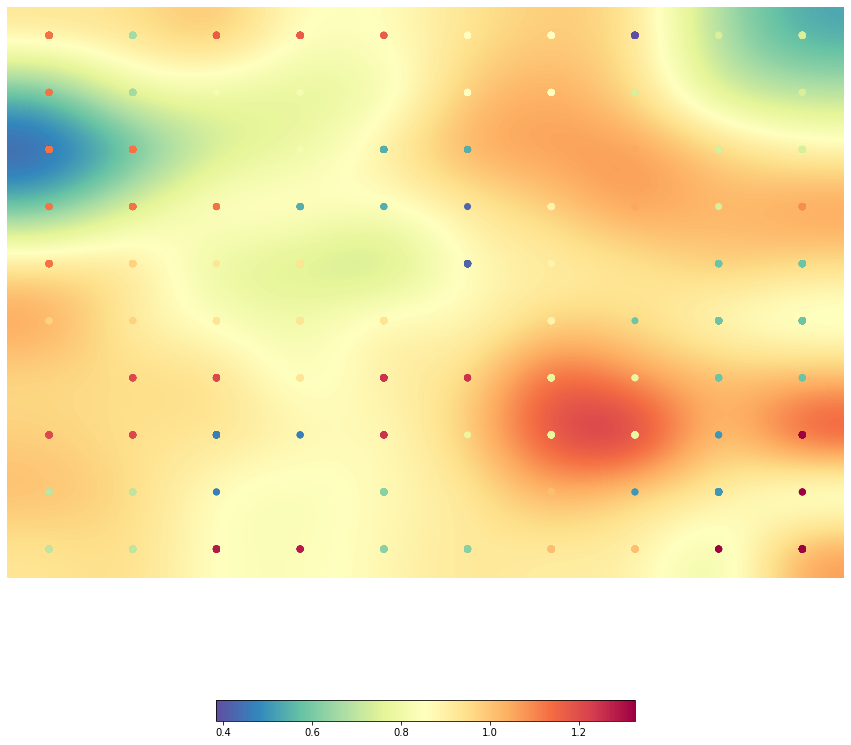

In [53]:
som.view_umatrix(bestmatches=True, colorbar=True,figsize=(15, 15)); matplotlib.pyplot.show()

Ο χάρτης παρουσιάζει κυρίως μόνο κόκκινες περιοχές, γι'αυτό κια θα χρειαστεί να αυξήσουμε τους νευρώνες του grid. Παρακάτω θα δημιουργήσουμε ένα grid 30x30.

In [54]:
print(som.clusters)

[[19  7 20 20 20 12 12  0  9  9]
 [19  7 11 11 11 12 12  9  9  9]
 [19 19 19 11  4  4 17 17  9  9]
 [19 19 19  4  4  1 13 17  9 18]
 [19 15 14 14 14  1 13 13  5  5]
 [15 15 14 14 14 14 13  5  5  5]
 [15 21 21 14 22 22 10 10  5  5]
 [21 21  2  2 22 10 10 10  3 24]
 [ 8  8  2 23  6  6 16  3  3 24]
 [ 8  8 23 23  6  6 16 16 24 24]]


In [55]:
print("Clusters sorted by increasing number of neurons:")
print('Custer Index')
print('Number of Neurons')
vals, counts = np.unique(som.clusters,return_counts=True)
sorted_counts = np.argsort(counts) # increasing sort
print(np.array([list(vals[sorted_counts]),list(counts[sorted_counts])]))

Clusters sorted by increasing number of neurons:
Custer Index
Number of Neurons
[[ 0 18  1  7  2  3 22 20 17 16 23 21 15 12 11  8  6  4 13 24 10  5 14  9
  19]
 [ 1  1  2  2  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4  4  5  7  8  8
   9]]



## Σημασιολογική ερμηνεία των clusters

Προκειμένου να μελετήσουμε τις τοπολογικές ιδιότητες του SOM και το αν έχουν ενσωματώσει σημασιολογική πληροφορία για τις ταινίες διαμέσου της διανυσματικής αναπαράστασης του tf-idf, των εμφυτευμάτων και των κατηγοριών, χρειαζόμαστε ένα κριτήριο ποιοτικής επισκόπησης των clusters. 

Θα υλοποιήσουμε το εξής κριτήριο: Λαμβάνουμε όρισμα έναν αριθμό (ετικέτα) cluster. Για το cluster αυτό βρίσκουμε όλους τους νευρώνες που του έχουν ανατεθεί από τον k-Means. Για όλους τους νευρώνες αυτούς βρίσκουμε όλες τις ταινίες που τους έχουν ανατεθεί (για τις οποίες αποτελούν bmus). Για όλες αυτές τις ταινίες τυπώνουμε ταξινομημένη τη συνολική στατιστική όλων των ειδών (κατηγοριών) και τις συχνότητές τους. Αν το cluster διαθέτει καλή συνοχή και εξειδίκευση, θα πρέπει κάποιες κατηγορίες να έχουν σαφώς μεγαλύτερη συχνότητα από τις υπόλοιπες. Θα μπορούμε τότε να αναθέσουμε αυτήν/ές την/τις κατηγορία/ες ως ετικέτες κινηματογραφικού είδους στο cluster.

Μπορείτε να υλοποιήσετε τη συνάρτηση αυτή όπως θέλετε. Μια πιθανή διαδικασία θα μπορούσε να είναι η ακόλουθη:

1. Ορίζουμε συνάρτηση `print_categories_stats` που δέχεται ως είσοδο λίστα με ids ταινιών. Δημιουργούμε μια κενή λίστα συνολικών κατηγοριών. Στη συνέχεια, για κάθε ταινία επεξεργαζόμαστε το string `categories` ως εξής: δημιουργούμε μια λίστα διαχωρίζοντας το string κατάλληλα με την `split` και αφαιρούμε τα whitespaces μεταξύ ετικετών με την `strip`. Προσθέτουμε τη λίστα αυτή στη συνολική λίστα κατηγοριών με την `extend`. Τέλος χρησιμοποιούμε πάλι την `np.unique` για να μετρήσουμε συχνότητα μοναδικών ετικετών κατηγοριών και ταξινομούμε με την `np.argsort`. Τυπώνουμε τις κατηγορίες και τις συχνότητες εμφάνισης ταξινομημένα. Χρήσιμες μπορεί να σας φανούν και οι `np.ravel`, `np.nditer`, `np.array2string` και `zip`.

In [56]:
def print_categories_stats(movie_IDs):
    total_categories = []
    for ID in movie_IDs:
        category = [cat.strip(" ").strip('"') for cat in categories[ID][0].split(",")] # split categories with , and strip spaces and "
        total_categories.extend(category)
    
    freqs, counts = np.unique(total_categories, return_counts = True) # count frequencies of unique category labels
    sorted_idx = np.argsort(counts)[::-1] # sort by decreasing freq
    
    stats = [(freqs[i], counts[i]) for i in sorted_idx]
    
    print('Overall Cluster Genres stats:')
    print(stats)
    return stats

2. Ορίζουμε τη βασική μας συνάρτηση `print_cluster_neurons_movies_report` που δέχεται ως όρισμα τον αριθμό ενός cluster. Με τη χρήση της `np.where` μπορούμε να βρούμε τις συντεταγμένες των bmus που αντιστοιχούν στο cluster και με την `column_stack` να φτιάξουμε έναν πίνακα bmus για το cluster. Προσοχή στη σειρά (στήλη - σειρά) στον πίνακα bmus. Για κάθε bmu αυτού του πίνακα ελέγχουμε αν υπάρχει στον πίνακα μοναδικών bmus που έχουμε υπολογίσει στην αρχή συνολικά και αν ναι προσθέτουμε το αντίστοιχο index του νευρώνα σε μια λίστα. Χρήσιμες μπορεί να είναι και οι `np.rollaxis`, `np.append`, `np.asscalar`. Επίσης πιθανώς να πρέπει να υλοποιήσετε ένα κριτήριο ομοιότητας μεταξύ ενός bmu και ενός μοναδικού bmu από τον αρχικό πίνακα bmus.

In [57]:
def print_cluster_neurons_movies_report(cluster_ID, bmus, indices, som_model):
    cluster_bmus = np.column_stack(np.where(som_model.clusters==cluster_ID)[::-1])
    
    neuron_idx = []
    for bmu in cluster_bmus:
        if bmu in bmus:
            neuron_idx.append(bmu)

    return neuron_idx

3. Υλοποιούμε μια βοηθητική συνάρτηση `neuron_movies_report`. Λαμβάνει ένα σύνολο νευρώνων από την `print_cluster_neurons_movies_report` και μέσω της `indices` φτιάχνει μια λίστα με το σύνολο ταινιών που ανήκουν σε αυτούς τους νευρώνες. Στο τέλος καλεί με αυτή τη λίστα την `print_categories_stats` που τυπώνει τις στατιστικές των κατηγοριών.

In [133]:
def neuron_movies_report(neurons, som_model):
    indices = []
    for neuron in neurons:
        indices.append(list(np.where(np.all(neuron==som_model.bmus,axis=1))[0]))
    indices = np.concatenate(indices)
    indices = [int(x) for x in indices] #convert to int
    stats = print_categories_stats(indices)
    return indices, stats

Μπορείτε βέβαια να προσθέσετε οποιαδήποτε επιπλέον έξοδο σας βοηθάει. Μια χρήσιμη έξοδος είναι πόσοι νευρώνες ανήκουν στο cluster και σε πόσους και ποιους από αυτούς έχουν ανατεθεί ταινίες.

Θα επιτελούμε τη σημασιολογική ερμηνεία του χάρτη καλώντας την `print_cluster_neurons_movies_report` με τον αριθμός ενός cluster που μας ενδιαφέρει. 

Παράδειγμα εξόδου για ένα cluster (μη βελτιστοποιημένος χάρτης, ωστόσο βλέπετε ότι οι μεγάλες κατηγορίες έχουν σημασιολογική  συνάφεια):

```
Overall Cluster Genres stats:  
[('"Horror"', 86), ('"Science Fiction"', 24), ('"B-movie"', 16), ('"Monster movie"', 10), ('"Creature Film"', 10), ('"Indie"', 9), ('"Zombie Film"', 9), ('"Slasher"', 8), ('"World cinema"', 8), ('"Sci-Fi Horror"', 7), ('"Natural horror films"', 6), ('"Supernatural"', 6), ('"Thriller"', 6), ('"Cult"', 5), ('"Black-and-white"', 5), ('"Japanese Movies"', 4), ('"Short Film"', 3), ('"Drama"', 3), ('"Psychological thriller"', 3), ('"Crime Fiction"', 3), ('"Monster"', 3), ('"Comedy"', 2), ('"Western"', 2), ('"Horror Comedy"', 2), ('"Archaeology"', 2), ('"Alien Film"', 2), ('"Teen"', 2), ('"Mystery"', 2), ('"Adventure"', 2), ('"Comedy film"', 2), ('"Combat Films"', 1), ('"Chinese Movies"', 1), ('"Action/Adventure"', 1), ('"Gothic Film"', 1), ('"Costume drama"', 1), ('"Disaster"', 1), ('"Docudrama"', 1), ('"Film adaptation"', 1), ('"Film noir"', 1), ('"Parody"', 1), ('"Period piece"', 1), ('"Action"', 1)]```

In [134]:
clusterID = 12
bmus, indices = np.unique(som.bmus,axis=0,return_index=True)
cluster_bmus = print_cluster_neurons_movies_report(clusterID, bmus, indices, som_model = som)
indices_, _ = neuron_movies_report(cluster_bmus, som_model = som)

Overall Cluster Genres stats:
[('Comedy', 104), ('Romance Film', 98), ('Romantic comedy', 88), ('Drama', 54), ('Romantic drama', 19), ('Indie', 18), ('Black-and-white', 15), ('Comedy-drama', 14), ('World cinema', 11), ('Musical', 11), ('Coming of age', 7), ('Teen', 5), ('Screwball comedy', 5), ('Comedy of manners', 4), ('Slapstick', 4), ('Sports', 4), ('Crime Fiction', 4), ('Thriller', 4), ('Ensemble Film', 4), ('Family Film', 4), ('Adventure', 4), ('Period piece', 4), ('Musical comedy', 3), ('Crime Comedy', 3), ('Action', 3), ('Sex comedy', 3), ('Parody', 3), ('Fantasy', 2), ('Biography', 2), ('Black comedy', 2), ('Comedy film', 2), ('Silent film', 2), ('Costume drama', 2), ('Satire', 2), ('Remake', 2), ('Mystery', 2), ('Music', 2), ('Workplace Comedy', 2), ('Feminist Film', 1), ("Children's", 1), ('Caper story', 1), ('Boxing', 1), ('Social problem film', 1), ('Melodrama', 1), ('Biopic [feature]', 1), ('Biographical film', 1), ('Slice of life story', 1), ('Beach Film', 1), ('Backstage


## Tips για το SOM και το clustering

- Για την ομαδοποίηση ένα U-matrix καλό είναι να εμφανίζει και μπλε-πράσινες περιοχές (clusters) και κόκκινες περιοχές (ορίων). Παρατηρήστε ποια σχέση υπάρχει μεταξύ αριθμού ταινιών στο final set, μεγέθους grid και ποιότητας U-matrix.
- Για το k του k-Means προσπαθήστε να προσεγγίζει σχετικά τα clusters του U-matrix (όπως είπαμε είναι διαφορετικοί μέθοδοι clustering). Μικρός αριθμός k δεν θα σέβεται τα όρια. Μεγάλος αριθμός θα δημιουργεί υπο-clusters εντός των clusters που φαίνονται στο U-matrix. Το τελευταίο δεν είναι απαραίτητα κακό, αλλά μεγαλώνει τον αριθμό clusters που πρέπει να αναλυθούν σημασιολογικά.
- Σε μικρούς χάρτες και με μικρά final sets δοκιμάστε διαφορετικές παραμέτρους για την εκπαίδευση του SOM. Σημειώστε τυχόν παραμέτρους που επηρεάζουν την ποιότητα του clustering για το dataset σας ώστε να τις εφαρμόσετε στους μεγάλους χάρτες.
- Κάποια τοπολογικά χαρακτηριστικά εμφανίζονται ήδη σε μικρούς χάρτες. Κάποια άλλα χρειάζονται μεγαλύτερους χάρτες. Δοκιμάστε μεγέθη 20x20, 25x25 ή και 30x30 και αντίστοιχη προσαρμογή των k. Όσο μεγαλώνουν οι χάρτες, μεγαλώνει η ανάλυση του χάρτη αλλά μεγαλώνει και ο αριθμός clusters που πρέπει να αναλυθούν.


Επαναλαμβάνουμε την άνωθι διαδικασία για ένα grid 30x30 και πειραματιζόμαστε για τον αριθμό των clusters k του αλγορίθμου k-means:

In [60]:
n_rows, n_columns = 30,30 # 30 x 30 map
som2 = somoclu.Somoclu(n_columns, n_rows, compactsupport=False)
%time som2.train(subset,epochs=100)

CPU times: user 52min 14s, sys: 8.02 s, total: 52min 22s
Wall time: 6min 55s


In [64]:
#joblib.dump(som2, 'som2.pkl')
#som2 = joblib.load('som2.pkl')

In [61]:
som2.cluster(KMeans(n_clusters=30))

In [62]:
bmus2, indices2 = np.unique(som2.bmus,axis=0,return_index=True)

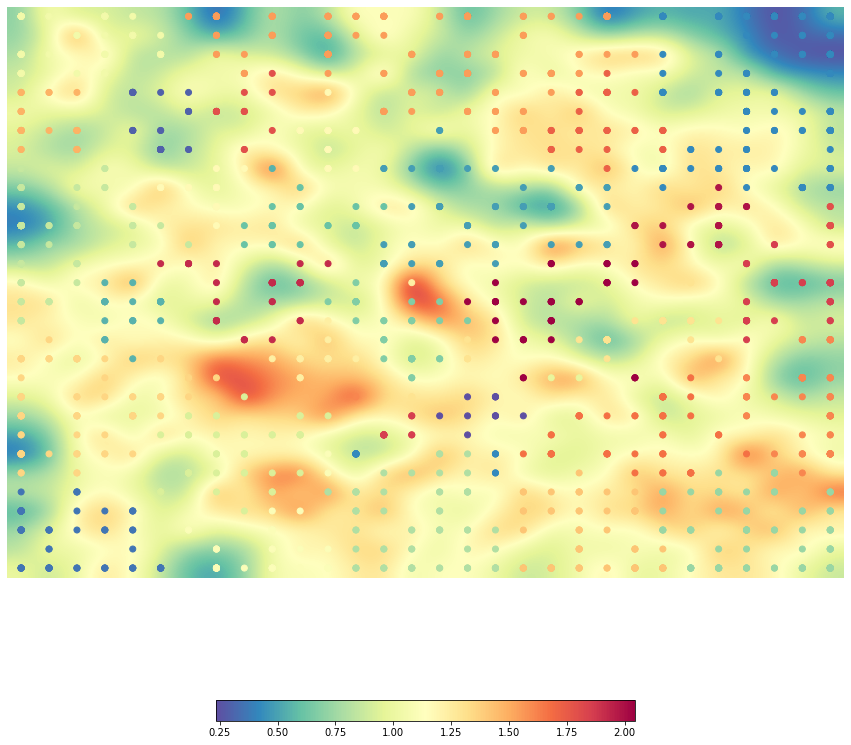

In [63]:
som2.view_umatrix(bestmatches=True, colorbar=True,figsize=(15, 15)); matplotlib.pyplot.show()

Οι μπλε και κόκκινες περιοχές φαίνονται πολύ καλύτερα σε σχέση με πριν.

In [183]:
print(som2.clusters)

[[13 13 13 13 13 13 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21  3
   3  3  3  3  3  3]
 [13 13 13 13 13 13 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21  3
   3  3  3  3  3  3]
 [13 13 13 13 13 13 13 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21  3
   3  3  3  3  3  3]
 [13 13 13 13  1 13  1 21 21 25 21 21 21 21 21 21 21 21 21 21 21 24 24  3
   3  3  3  3  3  3]
 [20 20 20  1  1  1  1 25 25 25 25 15 21 21 21 21 21 21 21 21 24 24 24  3
   3  3  3  3  3  3]
 [20 20 20  1  1  1  1 25 25 25 15 15 21 21 21 21 21 21 21 24 24 24 24 24
   3  3  3  3  3  3]
 [20 20 20 20  1  1  1 25 25 25 15 15 15 21 21  4 21 21 21 24 24 24 24 24
  24  3  3  3  3  3]
 [20 20 20 20  1  1  1  1 25 25 15 15 15  4  4  4  4 21 24 24 24 24 24 24
   3  3  3  3  3  3]
 [10 10 20 10  1  1  1 15 15  5 15 15 15  4  4  4  4  4  4  4  4 24  3  3
   3  3  3  3  3  3]
 [10 10 10 10 10 15 15 15 15 15  6 15  6  4  4  4  4  4  4  4  4  4  3  3
  28 28  3  3  3  3]
 [10 10 10 10 10 10 15 15 15  6  6  6  6  6  4  4 

In [65]:
print("Clusters sorted by increasing number of neurons:")
print('Custer Index')
print('Number of Neurons')
vals, counts = np.unique(som2.clusters,return_counts=True)
sorted_counts = np.argsort(counts) # increasing sort
print(np.array([list(vals[sorted_counts]),list(counts[sorted_counts])]))

Clusters sorted by increasing number of neurons:
Custer Index
Number of Neurons
[[12  0 16 20 25  5  6  1 28  7 24 15 13 14 17  2 27 19 22 26 29  8 23 11
   9 10 18  4  3 21]
 [ 4 10 12 15 18 18 18 20 20 21 23 24 24 24 26 26 27 29 31 31 32 36 38 38
  39 41 45 56 70 84]]


In [135]:
clusterID = 10
bmus2, indices2 = np.unique(som2.bmus,axis=0,return_index=True)
cluster_bmus = print_cluster_neurons_movies_report(clusterID, bmus2, indices2, som_model = som2)
indices_,_ = neuron_movies_report(cluster_bmus, som_model = som2)

Overall Cluster Genres stats:
[('Comedy', 118), ('Parody', 14), ('Adventure', 10), ('Crime Fiction', 10), ('World cinema', 9), ('Slapstick', 9), ('Musical', 7), ('Satire', 6), ('Black comedy', 5), ('Crime Comedy', 5), ('Teen', 5), ('Cult', 5), ('Coming of age', 4), ('Domestic Comedy', 4), ('Mystery', 4), ('Absurdism', 4), ('Sports', 4), ('Science Fiction', 4), ('Thriller', 4), ("Children's/Family", 3), ('Chinese Movies', 3), ('Fantasy', 3), ('Comedy-drama', 3), ('Comedy film', 3), ('Comedy Thriller', 3), ('Road movie', 3), ('Bollywood', 3), ('Action', 3), ('Screwball comedy', 3), ('Political cinema', 3), ('Political satire', 3), ('Caper story', 2), ('Slice of life story', 2), ('Buddy film', 2), ('War film', 2), ('Comedy of manners', 2), ('Spy', 2), ('Dance', 2), ('Fantasy Comedy', 2), ('Japanese Movies', 2), ('Master Criminal Films', 2), ('Mockumentary', 2), ('Heist', 2), ('Gangster Film', 2), ('Sex comedy', 2), ('Anime', 1), ("Children's", 1), ('Music', 1), ('Doomsday film', 1), ('Mar



## Ανάλυση τοπολογικών ιδιοτήτων χάρτη SOM

Μετά το πέρας της εκπαίδευσης και του clustering θα έχετε ένα χάρτη με τοπολογικές ιδιότητες ως προς τα είδη των ταίνιών της συλλογής σας, κάτι αντίστοιχο με την εικόνα στην αρχή της Εφαρμογής 2 αυτού του notebook. Η συγκεκριμένη εικόνα είναι μόνο για εικονογράφιση, δεν είναι χάρτης SOM καιδεν έχει καμία σχέση με τη συλλογή δεδομένων και τις κατηγορίες μας.

Για τον τελικό χάρτη SOM που θα παράξετε για τη συλλογή σας, αναλύστε σε markdown με συγκεκριμένη αναφορά σε αριθμούς clusters και τη σημασιολογική ερμηνεία τους τις εξής τρεις τοπολογικές ιδιότητες του SOM: 

1. Δεδομένα που έχουν μεγαλύτερη πυκνότητα πιθανότητας στο χώρο εισόδου τείνουν να απεικονίζονται με περισσότερους νευρώνες στο χώρο μειωμένης διαστατικότητας. Δώστε παραδείγματα από συχνές και λιγότερο συχνές κατηγορίες ταινιών. Χρησιμοποιήστε τις στατιστικές των κατηγοριών στη συλλογή σας και τον αριθμό κόμβων που χαρακτηρίζουν.
2. Μακρινά πρότυπα εισόδου τείνουν να απεικονίζονται απομακρυσμένα στο χάρτη. Υπάρχουν χαρακτηριστικές κατηγορίες ταινιών που ήδη από μικρούς χάρτες τείνουν να τοποθετούνται σε διαφορετικά ή απομονωμένα σημεία του χάρτη.
3. Κοντινά πρότυπα εισόδου τείνουν να απεικονίζονται κοντά στο χάρτη. Σε μεγάλους χάρτες εντοπίστε είδη ταινιών και κοντινά τους υποείδη.

Προφανώς τοποθέτηση σε 2 διαστάσεις που να σέβεται μια απόλυτη τοπολογία δεν είναι εφικτή, αφενός γιατί δεν υπάρχει κάποια απόλυτη εξ ορισμού για τα κινηματογραφικά είδη ακόμα και σε πολλές διαστάσεις, αφετέρου γιατί πραγματοποιούμε μείωση διαστατικότητας.

Εντοπίστε μεγάλα clusters και μικρά clusters που δεν έχουν σαφή χαρακτηριστικά. Εντοπίστε clusters συγκεκριμένων ειδών που μοιάζουν να μην έχουν τοπολογική συνάφεια με γύρω περιοχές. Προτείνετε πιθανές ερμηνείες.


Τέλος, εντοπίστε clusters που έχουν κατά την άποψή σας ιδιαίτερο ενδιαφέρον στη συλλογή της ομάδας σας (data exploration / discovery value) και σχολιάστε.


#### 1. Δεδομένα που έχουν μεγαλύτερη πυκνότητα πιθανότητας στο χώρο εισόδου τείνουν να απεικονίζονται με περισσότερους νευρώνες στο χώρο μειωμένης διαστατικότητας. Δώστε παραδείγματα από συχνές και λιγότερο συχνές κατηγορίες ταινιών. Χρησιμοποιήστε τις στατιστικές των κατηγοριών στη συλλογή σας και τον αριθμό κόμβων που χαρακτηρίζουν.

Σε πρώτη φάση, προσδιορίζουμε όλες τις μοναδικές κατηγορίες που εμφανίζονται στο subset των 2000 ταινιών σε συνδυασμό με τις συχνότητες εμφάνισης τους.

In [103]:
category_set = []

# Collect all categories of each movie in a list
for movie in range(len(subset)):
    cat = [category.strip(" ").strip('"') for category in categories[movie][0].split(",")]
    for categ in cat:
        category_set.append(categ)

# Create a dictionary of distinc categories and their frequencies
cat_freqs = {i:category_set.count(i) for i in set(category_set)}

# Sort Dictionary wrt to most common categories
cat_freqs_sorted = sorted(cat_freqs.items(), key=lambda cat_freqs: -cat_freqs[1])
print(cat_freqs_sorted)

[('Drama', 893), ('Comedy', 527), ('Romance Film', 320), ('Thriller', 300), ('Action', 280), ('World cinema', 224), ('Horror', 193), ('Crime Fiction', 190), ('Indie', 186), ('Black-and-white', 185), ('Short Film', 178), ('Adventure', 169), ('Action/Adventure', 169), ('Family Film', 143), ('Romantic drama', 119), ('Science Fiction', 116), ('Animation', 110), ('Romantic comedy', 108), ('Mystery', 108), ('Musical', 106), ('Comedy film', 98), ('Fantasy', 89), ('Silent film', 71), ('War film', 70), ('Period piece', 63), ('Crime Thriller', 61), ('Comedy-drama', 59), ('Documentary', 57), ('Western', 55), ('Psychological thriller', 52), ('Black comedy', 50), ('Bollywood', 48), ('Parody', 43), ('Chinese Movies', 41), ('Teen', 40), ('Film adaptation', 40), ('Coming of age', 38), ('Sports', 37), ("Children's/Family", 37), ('Japanese Movies', 34), ('Cult', 33), ('Slasher', 32), ('Television movie', 31), ('Political drama', 30), ('Biography', 27), ('Suspense', 27), ('Satire', 27), ('Family Drama', 

Παρατηρούμε ότι στο υποσύνολο των 2000 ταινιών, οι πιο συνηθισμένες κατηγορίες είναι **Drama, Comedy, Romance Film**, ενώ οι πιο σπάνιες είναι αυτές που εμφανίζονται μόλις 1 φορά (πχ Female Buddy Film, Vampire Movies). 

In [166]:
# Create Array of Distinct Categories
distinct_categories = np.array([tupl[0] for tupl in cat_freqs_sorted])

In [ ]:
total_neurons_per_cat = {}
# Print activated categories for each of the 30 clusters
for clusterID in range(30):
    ID_list, stats = neuron_movies_report([clusterID],som_model = som2)
    for pair in stats:
        if pair[0] in total_neurons_per_cat:
            total_neurons_per_cat[pair[0]] += pair[1]
        else:
            total_neurons_per_cat[pair[0]] = pair[1]

total_neurons_per_cat = sorted(total_neurons_per_cat.items(), key=lambda total_neurons_per_cat: -total_neurons_per_cat[1])

In [167]:
print('5 Most Activated Categories:\n')
for i in range(5):
    print(total_neurons_per_cat[i])
print('\n5 Least Activated Categories:\n')
for i in range(1,6):
    print(total_neurons_per_cat[-i])

5 Most Activated Categories:

('Comedy', 29)
('Short Film', 27)
('Action/Adventure', 26)
('Drama', 24)
('Animation', 21)

5 Least Activated Categories:

('B-Western', 1)
('Chase Movie', 1)
('Comedy Western', 1)
('Indian Western', 1)
('Satire', 1)


Παρατηρούμε ότι πράγματι οι κατηγορίες που έχουν μεγαλύτερες συχνότητες εμφάνισης, όπως Comedy, Action, Drama, τείνουν να απεικονίζονται σε περισσότερους νευρώνες στον χώρο μειωμένης διαστατικότητας, σε αντίθεση με τις πιο σπάνιες κατηγορίες, οι οποίες μετά βίας ενεργοποιούν μόλις έναν νευρώνα.

#### 2. Μακρινά πρότυπα εισόδου τείνουν να απεικονίζονται απομακρυσμένα στο χάρτη. Υπάρχουν χαρακτηριστικές κατηγορίες ταινιών που ήδη από μικρούς χάρτες τείνουν να τοποθετούνται σε διαφορετικά ή απομονωμένα σημεία του χάρτη.

In [178]:
clusterID = 6
bmus2, indices2 = np.unique(som2.bmus,axis=0,return_index=True)
cluster_bmus = print_cluster_neurons_movies_report(clusterID, bmus2, indices2, som_model = som2)
indices_,_ = neuron_movies_report(cluster_bmus, som_model = som2)

Overall Cluster Genres stats:
[('Romance Film', 21), ('Comedy', 21), ('Romantic comedy', 9), ('Black-and-white', 8), ('Musical', 7), ('Screwball comedy', 3), ('Musical comedy', 2), ('Sports', 2), ('Western', 1), ("Children's/Family", 1), ('Adventure', 1), ('Beach Film', 1), ('Boxing', 1), ('Fantasy', 1), ('Comedy film', 1), ('Crime Fiction', 1), ('Sex comedy', 1), ('Slapstick', 1), ('Action', 1)]


In [175]:
clusterID = 18
bmus2, indices2 = np.unique(som2.bmus,axis=0,return_index=True)
cluster_bmus = print_cluster_neurons_movies_report(clusterID, bmus2, indices2, som_model = som2)
indices_,_ = neuron_movies_report(cluster_bmus, som_model = som2)

Overall Cluster Genres stats:
[('Horror', 108), ('Slasher', 20), ('Comedy', 18), ('Cult', 18), ('B-movie', 16), ('Science Fiction', 14), ('Teen', 13), ('Creature Film', 13), ('Zombie Film', 9), ('Horror Comedy', 9), ('Black comedy', 8), ('Indie', 8), ('Natural horror films', 6), ('World cinema', 6), ('Monster movie', 5), ('Black-and-white', 4), ('Mystery', 4), ('Monster', 4), ('Short Film', 3), ('Japanese Movies', 3), ('Alien Film', 3), ('Television movie', 3), ('Drama', 3), ('Haunted House Film', 3), ('Fantasy', 3), ('Action/Adventure', 3), ('Psychological thriller', 3), ('Supernatural', 2), ('Animation', 2), ('Thriller', 2), ('Road-Horror', 2), ('Blaxploitation', 2), ('Chinese Movies', 2), ('Comedy film', 2), ('Film adaptation', 2), ('Doomsday film', 2), ('Splatter film', 2), ('Sci-Fi Horror', 2), ('Satire', 1), ('Adventure', 1), ('Sci Fi Pictures original films', 1), ('Apocalyptic and post-apocalyptic fiction', 1), ('Archaeology', 1), ('Parody', 1), ('Disaster', 1), ('Sports', 1), (

Στο παραπάνω παράδειγμα, βλέπουμε ότι το cluster 7 ενεργοποιεί κυρίως κατηγορίες Romance, Comedy, Romantic Comedy, Drama. Από την άλλη, το μακρινό cluster 18 ενεργοποιεί κυρίως κατηγορίες Thriller, Slasher, Horror κλπ. Με άλλα λόγια, μακρινά πρότυπα εισόδου τείνουν όντως να απεικονιστούν σε απομακρυσμένα clusters, δίχως ωστόσο να μην υπάρχουν εννοιολογικά σφάλματα, αφού μια τέλεια απεικόνιση όλων των κατηγοριών ταινιών στο επίπεδο είναι πρακτικά αδύνατη.

#### 3. Κοντινά πρότυπα εισόδου τείνουν να απεικονίζονται κοντά στο χάρτη. Σε μεγάλους χάρτες εντοπίστε είδη ταινιών και κοντινά τους υποείδη.

In [176]:
clusterID = 18
bmus2, indices2 = np.unique(som2.bmus,axis=0,return_index=True)
cluster_bmus = print_cluster_neurons_movies_report(clusterID, bmus2, indices2, som_model = som2)
indices_,_ = neuron_movies_report(cluster_bmus, som_model = som2)

Overall Cluster Genres stats:
[('Horror', 108), ('Slasher', 20), ('Comedy', 18), ('Cult', 18), ('B-movie', 16), ('Science Fiction', 14), ('Teen', 13), ('Creature Film', 13), ('Zombie Film', 9), ('Horror Comedy', 9), ('Black comedy', 8), ('Indie', 8), ('Natural horror films', 6), ('World cinema', 6), ('Monster movie', 5), ('Black-and-white', 4), ('Mystery', 4), ('Monster', 4), ('Short Film', 3), ('Japanese Movies', 3), ('Alien Film', 3), ('Television movie', 3), ('Drama', 3), ('Haunted House Film', 3), ('Fantasy', 3), ('Action/Adventure', 3), ('Psychological thriller', 3), ('Supernatural', 2), ('Animation', 2), ('Thriller', 2), ('Road-Horror', 2), ('Blaxploitation', 2), ('Chinese Movies', 2), ('Comedy film', 2), ('Film adaptation', 2), ('Doomsday film', 2), ('Splatter film', 2), ('Sci-Fi Horror', 2), ('Satire', 1), ('Adventure', 1), ('Sci Fi Pictures original films', 1), ('Apocalyptic and post-apocalyptic fiction', 1), ('Archaeology', 1), ('Parody', 1), ('Disaster', 1), ('Sports', 1), (

In [184]:
clusterID = 2
bmus2, indices2 = np.unique(som2.bmus,axis=0,return_index=True)
cluster_bmus = print_cluster_neurons_movies_report(clusterID, bmus2, indices2, som_model = som2)
indices_,_ = neuron_movies_report(cluster_bmus, som_model = som2)

Overall Cluster Genres stats:
[('Action', 83), ('Adventure', 26), ('Science Fiction', 19), ('Thriller', 19), ('Fantasy', 8), ('Western', 7), ('Horror', 7), ('Black-and-white', 6), ('Chinese Movies', 5), ('Crime Fiction', 5), ('Japanese Movies', 5), ('Indie', 5), ('Spy', 4), ('War film', 4), ('Mystery', 4), ('Fantasy Adventure', 3), ('World cinema', 3), ('Animation', 3), ('Comedy', 3), ('Comedy film', 3), ('Cult', 3), ('Family Film', 3), ('Martial Arts Film', 3), ('Alien Film', 2), ('Anime', 2), ('Computer Animation', 2), ('Superhero movie', 2), ('Historical fiction', 2), ('Silent film', 2), ('Spaghetti Western', 2), ('Romance Film', 2), ('Wuxia', 1), ('Glamorized Spy Film', 1), ('Adventure Comedy', 1), ('Sci-Fi Horror', 1), ('Sci-Fi Adventure', 1), ('Romantic fantasy', 1), ('Biographical film', 1), ('Bollywood', 1), ('Time travel', 1), ('Psychological thriller', 1), ('Parody', 1), ('Musical', 1), ('Swashbuckler films', 1), ('Movie serial', 1), ('Doomsday film', 1), ('Drama', 1), ('Ense

Παρατηρούμε ότι στο cluster με αριθμό 18 απεικονίζονται ταινίες horror, slasher, cult και επιστημονικής φαντασίας. Στο γειτονικό του cluster με αριθμό 2, απεικονίζονται θρίλερ δράσης, επιστημονικής φατνασίας adevnture movies. Εννοιολογικά, τα πρότυπα εισόδου αυτά είναι μεταξύ τους κοινά, αφού διέπονται από το κοινό στοιχείο της δράσης και της αγωνίας, γι'αυτό και απεικονίζονται σε κοντινά clusters στο επίπεδο.

Εντελώς ανάλογα για τα γειτονικά clusters με ID 6 και 4 βλέπουμε ότι κατά κύριο λόγο έχουμε κατηγορίες τύπου Romance, Romantic Comedy, Comedy, Musical, δηλαδή κατά βάση πρόσχαρες ταινίες:

In [179]:
clusterID = 6
bmus2, indices2 = np.unique(som2.bmus,axis=0,return_index=True)
cluster_bmus = print_cluster_neurons_movies_report(clusterID, bmus2, indices2, som_model = som2)
indices_,_ = neuron_movies_report(cluster_bmus, som_model = som2)

Overall Cluster Genres stats:
[('Romance Film', 21), ('Comedy', 21), ('Romantic comedy', 9), ('Black-and-white', 8), ('Musical', 7), ('Screwball comedy', 3), ('Musical comedy', 2), ('Sports', 2), ('Western', 1), ("Children's/Family", 1), ('Adventure', 1), ('Beach Film', 1), ('Boxing', 1), ('Fantasy', 1), ('Comedy film', 1), ('Crime Fiction', 1), ('Sex comedy', 1), ('Slapstick', 1), ('Action', 1)]


In [181]:
clusterID = 4
bmus2, indices2 = np.unique(som2.bmus,axis=0,return_index=True)
cluster_bmus = print_cluster_neurons_movies_report(clusterID, bmus2, indices2, som_model = som2)
indices_,_ = neuron_movies_report(cluster_bmus, som_model = som2)

Overall Cluster Genres stats:
[('Romance Film', 95), ('Drama', 63), ('Comedy', 13), ('Comedy film', 12), ('Musical', 9), ('War film', 5), ('Black-and-white', 5), ('Family Film', 4), ('Period piece', 4), ('Mystery', 3), ('Adventure', 3), ('Romantic comedy', 3), ('History', 3), ('Fantasy', 2), ('Music', 2), ('Crime Fiction', 2), ('Comedy-drama', 2), ('Historical fiction', 2), ('Biographical film', 2), ('Costume drama', 2), ('Chinese Movies', 2), ('Science Fiction', 1), ("Children's", 1), ('Biography', 1), ('Bollywood', 1), ('Short Film', 1), ('Biopic [feature]', 1), ('Backstage Musical', 1), ('Animation', 1), ('Animated Musical', 1), ('Coming of age', 1), ('Dance', 1), ('Courtroom Drama', 1), ('Musical comedy', 1), ('Docudrama', 1), ('Pre-Code', 1), ('Family Drama', 1), ('Silent film', 1), ('Feminist Film', 1), ('Filipino Movies', 1), ('Film adaptation', 1), ('Film u00e0 clef', 1), ('Gothic Film', 1), ('Horror', 1), ('Legal drama', 1), ('Melodrama', 1), ('Musical Drama', 1), ('Action', 1

#### Εντοπίστε μεγάλα clusters και μικρά clusters που δεν έχουν σαφή χαρακτηριστικά. Εντοπίστε clusters συγκεκριμένων ειδών που μοιάζουν να μην έχουν τοπολογική συνάφεια με γύρω περιοχές. Προτείνετε πιθανές ερμηνείες.

Βλέποντας καλύτερα τον χάρτη απεικόνισης στο 30x30 grid εστιάζουμε στο πολύ μικρό cluster με ID = 0 και τα γειτονικά του clusters:

In [193]:
clusterID = 0
bmus2, indices2 = np.unique(som2.bmus,axis=0,return_index=True)
cluster_bmus = print_cluster_neurons_movies_report(clusterID, bmus2, indices2, som_model = som2)
indices_,_ = neuron_movies_report(cluster_bmus, som_model = som2)

Overall Cluster Genres stats:
[('Romance Film', 12), ('Drama', 12), ('Thriller', 10), ('Crime Fiction', 8), ('Romantic drama', 4), ('Film adaptation', 3), ('World cinema', 2), ('Horror', 2), ('Black-and-white', 2), ('Film noir', 2), ('Mystery', 2), ('Indie', 1), ('Inspirational Drama', 1), ('War film', 1), ('Fantasy', 1), ('Psychological thriller', 1), ('Crime Thriller', 1), ('Science Fiction', 1), ('Crime Drama', 1), ('Coming of age', 1), ('Vampire movies', 1), ('Art film', 1), ('Adventure', 1), ('Action', 1)]


Παρατηρούμε ότι το εν λόγω cluster φαίνεται να μην έχει αυστηρά καθορισμένα χαρακτηριστικά, καθώς ενεργοποιεί κατηγορίες που εκ πρώτης όψεως φαντάζουν αντιφατικές: από τη μία romantic film, romantic drama και από την άλλη thriller και crime fiction. Θέλοντας να κατανοήσουμε περισσότερο το εν λόγω cluster μελετάμε τους γείτονες του.

Από πάνω συνορεύει με τα μεγαλύτερα σε μέγεθος **clusters 29 και 7**, τα οποία συνδέονται κυρίως με το ρομάντζο και το δράμα:

In [190]:
clusterID = 29
bmus2, indices2 = np.unique(som2.bmus,axis=0,return_index=True)
cluster_bmus = print_cluster_neurons_movies_report(clusterID, bmus2, indices2, som_model = som2)
indices_,_ = neuron_movies_report(cluster_bmus, som_model = som2)

Overall Cluster Genres stats:
[('Drama', 45), ('Romantic drama', 45), ('Romance Film', 40), ('Period piece', 11), ('Film adaptation', 7), ('Black-and-white', 7), ('Indie', 5), ('War film', 4), ('Costume drama', 3), ('Melodrama', 3), ('Musical', 3), ('Fantasy', 2), ('Historical fiction', 2), ('Marriage Drama', 2), ('Coming of age', 2), ('Ensemble Film', 2), ('Silent film', 2), ('Courtroom Drama', 1), ('Comedy-drama', 1), ('Comedy', 1), ('Crime Fiction', 1), ('Chinese Movies', 1), ('Biography', 1), ('Americana', 1), ('Disaster', 1), ('Addiction Drama', 1), ('Western', 1), ('Horror', 1), ('Epic', 1), ('Family Drama', 1), ('Fantasy Drama', 1), ('Kitchen sink realism', 1), ('Monster', 1), ('Musical Drama', 1), ('Mystery', 1), ('Roadshow theatrical release', 1), ('Romantic comedy', 1), ('Romantic fantasy', 1), ('Science Fiction', 1), ('Teen', 1), ('Television movie', 1), ('Thriller', 1), ('Action/Adventure', 1)]


In [195]:
clusterID = 7
bmus2, indices2 = np.unique(som2.bmus,axis=0,return_index=True)
cluster_bmus = print_cluster_neurons_movies_report(clusterID, bmus2, indices2, som_model = som2)
indices_,_ = neuron_movies_report(cluster_bmus, som_model = som2)

Overall Cluster Genres stats:
[('Romance Film', 33), ('Drama', 33), ('Comedy', 32), ('Romantic comedy', 31), ('Romantic drama', 24), ('World cinema', 12), ('Comedy-drama', 6), ('Black-and-white', 4), ('Ensemble Film', 3), ('Family Film', 3), ('Musical', 3), ('Indie', 2), ('Bollywood', 2), ('Comedy of manners', 2), ('Thriller', 2), ('Fantasy', 2), ('Period piece', 2), ('Sports', 2), ('Kitchen sink realism', 1), ('Screwball comedy', 1), ('Action/Adventure', 1), ('Adventure', 1), ('Backstage Musical', 1), ('Biography', 1), ('Biopic [feature]', 1), ('Black comedy', 1), ('Slapstick', 1), ('Caper story', 1), ("Children's/Family", 1), ('Silent film', 1), ('Political drama', 1), ('Music', 1), ('Costume drama', 1), ('Crime Comedy', 1), ('Crime Fiction', 1), ('Domestic Comedy', 1), ('Political cinema', 1), ('Parody', 1), ('Mystery', 1), ('Feminist Film', 1), ('Filipino Movies', 1), ('Film adaptation', 1), ('Holiday Film', 1), ('Action', 1)]


Από κάτω συνορεύει με τα μεγαλύτερα σε πλήθος **clusters με ID 9 και 23** τα οποία είναι κυρίως ταινίες δράσης/πολέμου και θρίλερ με έντονο το στοιχείο του δράματος:

In [188]:
clusterID = 9
bmus2, indices2 = np.unique(som2.bmus,axis=0,return_index=True)
cluster_bmus = print_cluster_neurons_movies_report(clusterID, bmus2, indices2, som_model = som2)
indices_,_ = neuron_movies_report(cluster_bmus, som_model = som2)

Overall Cluster Genres stats:
[('Thriller', 65), ('Crime Fiction', 46), ('Drama', 44), ('Mystery', 34), ('Crime Thriller', 31), ('Suspense', 17), ('Black-and-white', 13), ('Psychological thriller', 12), ('Film noir', 9), ('World cinema', 7), ('Indie', 7), ('Comedy', 7), ('Detective', 6), ('Film adaptation', 5), ('Detective fiction', 4), ('Horror', 4), ('Black comedy', 4), ('Period piece', 4), ('Gangster Film', 3), ('Crime Drama', 3), ('Melodrama', 3), ('Action', 3), ('Supernatural', 2), ('Political drama', 2), ('Political thriller', 2), ('Courtroom Drama', 2), ('Comedy-drama', 2), ('Caper story', 2), ('Ensemble Film', 2), ('Fantasy', 2), ('Comedy film', 1), ('Crime Comedy', 1), ('Creature Film', 1), ('Coming of age', 1), ('Neo-noir', 1), ('Television movie', 1), ('Blaxploitation', 1), ('Tragedy', 1), ('War film', 1), ('Biographical film', 1), ('Adventure', 1), ('Time travel', 1), ('Cult', 1), ('Teen', 1), ('Parody', 1), ('Spy', 1), ('Slasher', 1), ('Doomsday film', 1), ('Science Fictio

In [196]:
clusterID = 23
bmus2, indices2 = np.unique(som2.bmus,axis=0,return_index=True)
cluster_bmus = print_cluster_neurons_movies_report(clusterID, bmus2, indices2, som_model = som2)
indices_,_ = neuron_movies_report(cluster_bmus, som_model = som2)

Overall Cluster Genres stats:
[('Action', 56), ('Drama', 54), ('War film', 11), ('Crime Fiction', 9), ('Romance Film', 9), ('Thriller', 8), ('Action/Adventure', 7), ('Adventure', 7), ('Sports', 4), ('Western', 4), ('Period piece', 4), ('Mystery', 4), ('Black-and-white', 4), ('Biography', 3), ('Television movie', 3), ('Bollywood', 2), ('Combat Films', 2), ('Coming of age', 2), ('Docudrama', 2), ('World cinema', 2), ('Musical', 2), ('History', 2), ('Political drama', 2), ('Indie', 2), ('Family Film', 2), ('Historical fiction', 2), ('Historical drama', 2), ('Crime Drama', 1), ('Science Fiction', 1), ('Action Thrillers', 1), ('Teen', 1), ('Spy', 1), ('Anti-war', 1), ('Anti-war film', 1), ('Biographical film', 1), ('Psychological thriller', 1), ('Crime Comedy', 1), ('Buddy film', 1), ('Film noir', 1), ('Comedy', 1), ('Comedy film', 1), ('Costume drama', 1), ('Film adaptation', 1)]


Παρατηρούμε λοιπόν ότι το πολύ μικρό cluster με ID = 0, βρίσκεται στη συγκεκριμένη θέση του χάρτη για να αποτελέσει **ένα είδος γέφυρας ή μετάβασης** από το δράμα που διέπει τις ρομαντικές ταινίες στο δράμα που διέπει τις ταινίες δράσης, τα θρίλερ και τις ταινίες πολέμου.

Εντελώς ανάλογα μπορούμε να πούμε για **το πολύ μικρό cluster με ID = 12**, το οποίο επίσης δεν φαίνεται να έχει αυστηρώς καθορισμένα χαρακτηριστικά και περιβάλλεται από τα clusters 29 και 23, τα οποία είναι κυρίως romance-drama και action-drama. Επίσης κοντινό είναι το cluster 17 που υπάγεται στην κατηγορία world cinema. Συνεπώς το μικρό κέντρο με ID = 12 αποτελεί συνδετικό κρίκο για τρεις περιοχές.

In [198]:
clusterID = 12
bmus2, indices2 = np.unique(som2.bmus,axis=0,return_index=True)
cluster_bmus = print_cluster_neurons_movies_report(clusterID, bmus2, indices2, som_model = som2)
indices_,_ = neuron_movies_report(cluster_bmus, som_model = som2)

Overall Cluster Genres stats:
[('World cinema', 2), ('Romantic drama', 2), ('Romance Film', 2), ('Drama', 2), ('Action', 2), ('Thriller', 1), ('Tamil cinema', 1), ('Musical', 1), ('Family Film', 1)]


In [200]:
clusterID = 17
bmus2, indices2 = np.unique(som2.bmus,axis=0,return_index=True)
cluster_bmus = print_cluster_neurons_movies_report(clusterID, bmus2, indices2, som_model = som2)
indices_,_ = neuron_movies_report(cluster_bmus, som_model = som2)

Overall Cluster Genres stats:
[('World cinema', 41), ('Romance Film', 40), ('Drama', 40), ('Romantic drama', 36), ('Bollywood', 15), ('Musical', 12), ('Comedy', 7), ('Art film', 3), ('War film', 2), ('Filipino Movies', 2), ('Coming of age', 2), ('Crime Fiction', 1), ('Black comedy', 1), ('Comedy film', 1), ('Biography', 1), ('Avant-garde', 1), ('Black-and-white', 1), ('Experimental film', 1), ('Docudrama', 1), ('Documentary', 1), ('Fantasy', 1), ('Juvenile Delinquency Film', 1), ('Music', 1), ('Mystery', 1), ('Political cinema', 1), ('Political drama', 1), ('Road movie', 1), ('Romantic comedy', 1), ('Action/Adventure', 1)]


#### Τέλος, εντοπίστε clusters που έχουν κατά την άποψή σας ιδιαίτερο ενδιαφέρον στη συλλογή της ομάδας σας (data exploration / discovery value) και σχολιάστε.

Τέλος, εστιάζουμε στα clusters που αποτελούν τις πιο μπλε περιοχές του χάρτη απεικόνισης. Ειδικότερα:
- Η πρώτη μπλε περιοχή βρίσκεται στην τέρμα πάνω δεξιά γωνία του χάρτη και αντιστοιχεί κυρίως σε cluster ID = 3.
- Η δεύτερη μπλε περιοχή βρίσκεται τέρμα αριστερά στα μέσα του χάρτη και αντιστοιχεί κυρίως σε cluster ID = 10.
- Η τρίτη μπλε περιοχή βρίσκεται κάτω και τέρμα αριστερά του χάρτη και αντιστοιχεί κυρίως σε cluster ID = 2.
- Η τέταρτη μπλε περιοχή βρίσκεται περίπου στο κέντρο του χάρτη και αντιστοιχεί κυρίως σε cluster ID = 4.

In [204]:
clusterID = 3
bmus2, indices2 = np.unique(som2.bmus,axis=0,return_index=True)
cluster_bmus = print_cluster_neurons_movies_report(clusterID, bmus2, indices2, som_model = som2)
indices_,_ = neuron_movies_report(cluster_bmus, som_model = som2)

Overall Cluster Genres stats:
[('Drama', 337), ('Crime Fiction', 25), ('Black-and-white', 20), ('War film', 19), ('Period piece', 16), ('Television movie', 14), ('Comedy film', 14), ('Family Film', 12), ('Adventure', 11), ('Thriller', 11), ('Political drama', 11), ('Biopic [feature]', 11), ('Short Film', 10), ('Biography', 10), ('Biographical film', 10), ('Melodrama', 9), ('Family Drama', 8), ('Mystery', 8), ('Film adaptation', 8), ('Musical', 7), ('Sports', 6), ('Chinese Movies', 5), ('History', 5), ('Horror', 5), ('Docudrama', 5), ('Costume drama', 5), ('Film noir', 4), ('Epic', 4), ('Pre-Code', 4), ('Satire', 3), ('Coming of age', 3), ('Crime Drama', 3), ('Silent film', 3), ('Prison', 3), ('Music', 3), ('Christian film', 3), ('Black comedy', 3), ('Ensemble Film', 2), ('Detective', 2), ('Detective fiction', 2), ('Childhood Drama', 2), ('Comedy-drama', 2), ("Children's/Family", 2), ('Fantasy', 2), ('Gangster Film', 2), ('Addiction Drama', 2), ('Slice of life story', 2), ('Historical d

In [205]:
clusterID = 10
bmus2, indices2 = np.unique(som2.bmus,axis=0,return_index=True)
cluster_bmus = print_cluster_neurons_movies_report(clusterID, bmus2, indices2, som_model = som2)
indices_,_ = neuron_movies_report(cluster_bmus, som_model = som2)

Overall Cluster Genres stats:
[('Comedy', 118), ('Parody', 14), ('Adventure', 10), ('Crime Fiction', 10), ('World cinema', 9), ('Slapstick', 9), ('Musical', 7), ('Satire', 6), ('Black comedy', 5), ('Crime Comedy', 5), ('Teen', 5), ('Cult', 5), ('Coming of age', 4), ('Domestic Comedy', 4), ('Mystery', 4), ('Absurdism', 4), ('Sports', 4), ('Science Fiction', 4), ('Thriller', 4), ("Children's/Family", 3), ('Chinese Movies', 3), ('Fantasy', 3), ('Comedy-drama', 3), ('Comedy film', 3), ('Comedy Thriller', 3), ('Road movie', 3), ('Bollywood', 3), ('Action', 3), ('Screwball comedy', 3), ('Political cinema', 3), ('Political satire', 3), ('Caper story', 2), ('Slice of life story', 2), ('Buddy film', 2), ('War film', 2), ('Comedy of manners', 2), ('Spy', 2), ('Dance', 2), ('Fantasy Comedy', 2), ('Japanese Movies', 2), ('Master Criminal Films', 2), ('Mockumentary', 2), ('Heist', 2), ('Gangster Film', 2), ('Sex comedy', 2), ('Anime', 1), ("Children's", 1), ('Music', 1), ('Doomsday film', 1), ('Mar

In [211]:
clusterID = 2
bmus2, indices2 = np.unique(som2.bmus,axis=0,return_index=True)
cluster_bmus = print_cluster_neurons_movies_report(clusterID, bmus2, indices2, som_model = som2)
indices_,_ = neuron_movies_report(cluster_bmus, som_model = som2)

Overall Cluster Genres stats:
[('Action', 83), ('Adventure', 26), ('Science Fiction', 19), ('Thriller', 19), ('Fantasy', 8), ('Western', 7), ('Horror', 7), ('Black-and-white', 6), ('Chinese Movies', 5), ('Crime Fiction', 5), ('Japanese Movies', 5), ('Indie', 5), ('Spy', 4), ('War film', 4), ('Mystery', 4), ('Fantasy Adventure', 3), ('World cinema', 3), ('Animation', 3), ('Comedy', 3), ('Comedy film', 3), ('Cult', 3), ('Family Film', 3), ('Martial Arts Film', 3), ('Alien Film', 2), ('Anime', 2), ('Computer Animation', 2), ('Superhero movie', 2), ('Historical fiction', 2), ('Silent film', 2), ('Spaghetti Western', 2), ('Romance Film', 2), ('Wuxia', 1), ('Glamorized Spy Film', 1), ('Adventure Comedy', 1), ('Sci-Fi Horror', 1), ('Sci-Fi Adventure', 1), ('Romantic fantasy', 1), ('Biographical film', 1), ('Bollywood', 1), ('Time travel', 1), ('Psychological thriller', 1), ('Parody', 1), ('Musical', 1), ('Swashbuckler films', 1), ('Movie serial', 1), ('Doomsday film', 1), ('Drama', 1), ('Ense

In [216]:
clusterID = 4
bmus2, indices2 = np.unique(som2.bmus,axis=0,return_index=True)
cluster_bmus = print_cluster_neurons_movies_report(clusterID, bmus2, indices2, som_model = som2)
indices_,_ = neuron_movies_report(cluster_bmus, som_model = som2)

Overall Cluster Genres stats:
[('Romance Film', 95), ('Drama', 63), ('Comedy', 13), ('Comedy film', 12), ('Musical', 9), ('War film', 5), ('Black-and-white', 5), ('Family Film', 4), ('Period piece', 4), ('Mystery', 3), ('Adventure', 3), ('Romantic comedy', 3), ('History', 3), ('Fantasy', 2), ('Music', 2), ('Crime Fiction', 2), ('Comedy-drama', 2), ('Historical fiction', 2), ('Biographical film', 2), ('Costume drama', 2), ('Chinese Movies', 2), ('Science Fiction', 1), ("Children's", 1), ('Biography', 1), ('Bollywood', 1), ('Short Film', 1), ('Biopic [feature]', 1), ('Backstage Musical', 1), ('Animation', 1), ('Animated Musical', 1), ('Coming of age', 1), ('Dance', 1), ('Courtroom Drama', 1), ('Musical comedy', 1), ('Docudrama', 1), ('Pre-Code', 1), ('Family Drama', 1), ('Silent film', 1), ('Feminist Film', 1), ('Filipino Movies', 1), ('Film adaptation', 1), ('Film u00e0 clef', 1), ('Gothic Film', 1), ('Horror', 1), ('Legal drama', 1), ('Melodrama', 1), ('Musical Drama', 1), ('Action', 1

Παρατηρούμε ότι τα παραπάνω clusters δίνουν αντίστοιχα κατηγορίες ταινιών **Drama, Comedy, Action και Romance**, οι οποίες όπως δείξαμε είναι και οι πιο συνηθισμένες κατηγορίες ταινιών. Για τον λόγο αυτόν, τα εν λόγω clusters θα ενεργοποιούνται για το μεγαλύτερο πλήθος ταινιών εισόδου και είναι ιδιαίτερου ενδιαφέροντος.


# Τελική παράδοση άσκησης

- Θα παραδώσετε στο helios το παρόν notebook επεξεργασμένο ή ένα ή δύο νέα zipαρισμένα με τις απαντήσεις σας για τα ζητούμενα και των δύο εφαρμογών. 
- Θυμηθείτε ότι η ανάλυση του χάρτη στο markdown με αναφορά σε αριθμούς clusters πρέπει να αναφέρεται στον τελικό χάρτη με τα κελιά ορατά που θα παραδώσετε αλλιώς ο χάρτης που θα προκύψει θα είναι διαφορετικός και τα labels των clusters δεν θα αντιστοιχούν στην ανάλυσή σας. 
- Μην ξεχάσετε στην αρχή ένα κελί markdown με **τα στοιχεία της ομάδας σας**.

<table>
  <tr><td align="center">
    <font size="4">Παρακαλούμε διατρέξτε βήμα-βήμα το notebook για να μην ξεχάσετε παραδοτέα</font>
</td>
  </tr>
</table>